## to do the analysis:
-	iloc warnings update to current version.
-	3d plots with bodyweight
- 	auc plots logy axis 


## Plots for manuscript
Which plots:
-   caffeine clearance / doses
-   caffeine half life / doses/kg
Different variants of plot
- only strict data & remove outliers & rest! (describe the criteria of data selection in legend, i.e. healthy, smoking, ...; and outlier removal!); for males oc=F must be inferred -> check and document;
- create rest/unknown category of all data which has missing smoking or oc information.
- all symbols are circles!, only change colors for subgroups: control, smoking, oc, oc-smoking, rest
- Two variants of plot: (i) only raw outputs and (ii) raw outputs + calculated (used different symbol for calculated)
- check errorbars for dose/kg 
- make plot square
- doses in [mg] and [mg/kg]; clearance in [ml/min]; thalf [hr];
- size of marker according to groupsize
- more concise legend,e.g., control (I=190, G=47, TI=2001)
- remove title, remove grid
- add histograms on y-Axis
- add interpolation curve for groups

- Create same plots with outliers + rest (supplement) & clearly mark the outliers and rest with different symbols;




## Manuscript: 

- update figure 3 second image (strict query) (make image legend and write method section ( how was the image created)
- add overview tables in suplements
- substance diagram on left side (add legend , add method section)


In [255]:
import pandas as pd
import numpy as np
from collections import namedtuple
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.lines import Line2D
import os
plt.style.use('seaborn-white')
import matplotlib
from matplotlib.ticker import MaxNLocator
import matplotlib.ticker as ticker



from utils import PkdbModel, abs_idx,rel_idx,group_idx,individual_idx \

plt.rcParams.update({
        'axes.labelsize': '20',
        'axes.labelweight': 'bold',
        'axes.titlesize': 'medium',
        'axes.titleweight': 'bold',
        'legend.fontsize': '20',
        'xtick.labelsize': '20',
        'ytick.labelsize': '20',
        'figure.facecolor': '1.00'
    })


In [256]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [257]:
caffeine_clr = PkdbModel("caffeine_clearance",destination="3-inferred")
caffeine_clr.read()
caffeine_clearance = caffeine_clr.data
caffeine_clearance["outlier"] = False


In [258]:
# filter out outliers probably from same clinical study 

In [259]:
caffeine_clearance.loc[caffeine_clearance["study"]== "Balogh1992","outlier"] = True
caffeine_clearance.loc[caffeine_clearance["study"]== "Harder1988","outlier"] = True
caffeine_clearance.loc[caffeine_clearance["study"]== "Harder1989","outlier"] = True

In [260]:

def control_idx(data):
    return ( data[ ('smoking', 'choice')] == 'N') \
           & (data.outlier == False) \
           & ((data[ ('oral contraceptives', 'choice')] == 'N') | ((data[('oral contraceptives', 'choice')].isnull()) & (data[('medication', 'choice')] == "N")))

def smoking_idx(data):
    return (data[ ('smoking', 'choice')] == 'Y') \
           & (data.outlier == False) \

def oc_idx(data):
    return (data.outlier == False) \
           & (data[ ('oral contraceptives', 'choice')] == 'Y') 

def outlier_idx(data):
    return  data.outlier == True

def rest_idx(data):
    return (~outlier_idx(data) & ~smoking_idx(data)  & ~oc_idx(data) & ~control_idx(data))

In [261]:
class FigureTemplate(object):
    def __init__(self,data_idx,intervention_type, output_type):
        self.data_idx = data_idx,
        self.intervention_type = intervention_type
        self.output_type = output_type
        self.figure=False,
        self.ax = False
    
    def data_subset(self,data):
        return data.loc[self.data_idx]
    
    def create_figure(self, data):
        if len(self.data_subset(data)) > 0:
             self.figure, self.ax  =  plt.subplots(nrows=1, ncols=1, figsize=(15, 15))


In [262]:
PlotCategory =  namedtuple('PlotCategory', ['name','color', 'marker','data_idx'])

def control_idx_strict(data):
    return ( data[ ('smoking', 'choice')] == 'N') \
           & (data.outlier == False) \
           & (data[ ('oral contraceptives', 'choice')] == 'N')
def smoking_idx_strict(data):
    return (data[ ('smoking', 'choice')] == 'Y') \
         & (data[ ('oral contraceptives', 'choice')] == 'N') \
           & (data.outlier == False) 

def oc_idx_strict(data):
    return (data.outlier == False) \
           & (data[ ('oral contraceptives', 'choice')] == 'Y') \
            & (data[ ('smoking', 'choice')] == 'N') 

def oc_smoking_strict(data):
    return (data.outlier == False) \
           & (data[ ('oral contraceptives', 'choice')] == 'Y') \
            & (data[ ('smoking', 'choice')] == 'Y') 

def rest_idx_strict(data):
        return (~control_idx_strict(data) & ~smoking_idx_strict(data) & ~oc_smoking_strict(data)  & ~oc_idx_strict(data) & ~outlier_idx(data))



In [263]:
colors = sns.color_palette("colorblind",n_colors=5)

In [264]:
categories_soft = [              
              PlotCategory(name="UNKOWN", color="darkgray", marker='o', data_idx=rest_idx),
              PlotCategory(name="CONTROL", color=colors[2], marker='o', data_idx=control_idx),
              PlotCategory(name="SMOKING", color=colors[0], marker='o', data_idx=smoking_idx),
              PlotCategory(name="OC", color=colors[3], marker='o', data_idx=oc_idx),
              #PlotCategory(name="outlier", color='red', marker='x', data_idx=outlier_idx),
             ]

In [265]:
categories_strict = [
              PlotCategory(name="UNKOWN", color="darkgray", marker='o', data_idx=rest_idx_strict),
              PlotCategory(name="CONTROL", color=colors[2], marker='o', data_idx=control_idx_strict),
              PlotCategory(name="SMOKING", color=colors[0], marker='o', data_idx=smoking_idx_strict),
              PlotCategory(name="OC", color=colors[3], marker='o', data_idx=oc_idx_strict),
              PlotCategory(name="OC-SMOKING", color=colors[1], marker='o', data_idx=oc_smoking_strict),
              #PlotCategory(name="outlier", color='red', marker='x', data_idx=outlier_idx),
             ]

In [266]:


def create_figures(df_data):
    figure_templates = [FigureTemplate(
        data_idx= abs_idx(df_data,"unit_intervention") & abs_idx(df_data,"unit"),
        intervention_type = "abs",
        output_type = "abs"
                  ),
    FigureTemplate(
        data_idx= rel_idx(df_data,"unit_intervention") & abs_idx(df_data,"unit"),
        intervention_type = "rel",
        output_type = "abs"
                  ),
    FigureTemplate(
        data_idx= abs_idx(df_data,"unit_intervention") & rel_idx(df_data,"unit"),
        intervention_type = "abs",
        output_type = "rel"
                  ),
    FigureTemplate(
        data_idx= rel_idx(df_data,"unit_intervention") & rel_idx(df_data,"unit"),
        intervention_type = "rel",
        output_type = "rel"
                  )
    ]
    
    for figure_template in figure_templates:
        
        figure_template.create_figure(df_data)
    return figure_templates
        
    
    


In [277]:

import matplotlib.font_manager as font_manager
font = font_manager.FontProperties(family='Roboto Mono',
                                   weight='normal',
                                   style='normal', size=16,) 

category_mapper = {
    "thalf": "half time"
}

def create_plots(df_data,categories,fig_path,pktype, log_y=False):
    
    
    figures = create_figures(df_data)
    
    for figure in figures:
        if figure.ax:
            df_figure = figure.data_subset(df_data)
            
            df_figure_max = max([df_figure["value"].max(),df_figure["mean"].max()])*1.05
            df_figure_x_max =df_figure["value_intervention"].max()*1.05
            
            df_figure_min = min([df_figure["value"].min(),df_figure["mean"].min()])/1.05

        
            df_individual = df_figure[individual_idx(df_data)]
            df_group = df_figure[group_idx(df_data)]

            legend_elements = []
            for plot_category in categories:
                
                
                
                
                df_category = df_individual[plot_category.data_idx(df_individual)]
                
                units = df_category["unit"].unique()
                units_intervention = df_category["unit_intervention"].unique()
                assert len(units) <= 1, units
                try:
                    unit = units[0]
                    unit_intervention = units_intervention[0]
                    
                    y_axis = category_mapper
                    
                    y_axis_label = category_mapper.get(pktype,pktype)

                    figure.ax.set_ylabel(f'{y_axis_label} [{unit}]')
                    figure.ax.set_xlabel(f'dose [{unit_intervention}]')
                    figure.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

                except IndexError: 
                    pass
                
                
                individuals_number = len(df_category)
                
                for calculated, df_individuals in df_category.groupby("calculated"):
                    if calculated:
                        marker = "s"
                    else:
                        marker = plot_category.marker

                    x = df_individuals["value_intervention"]
                    y = df_individuals["value"]
                    figure.ax.scatter(x, y,color=plot_category.color, marker=marker, alpha=0.7,label=None,  s=20)

                

                

                df_category = df_group[plot_category.data_idx(df_group)]
                df_category = df_category[df_category["mean"].notnull()]
                group_number = len(df_category)
                total_group_individuals = 0
                x_group_max = df_category["value_intervention"].max()
                y_group_max = df_category["mean"].max()

                for i, df_row in df_category.iterrows():
                    if df_row["calculated"]:
                        marker = "s"
                    else:
                        marker = plot_category.marker

                    x_group = df_row["value_intervention"]
                    y_group = df_row["mean"]

                    if figure.output_type == "rel":
                        xerr_group = (df_row[("weight","sd")]/df_row[("weight","mean")])*x_group
                    else:
                        xerr_group = 0
                    yerr_group = df_row["se"]
                    group_count = df_row['group_count']
                    total_group_individuals += group_count
                    
                

                    figure.ax.errorbar(x_group, y_group,yerr=yerr_group,xerr=xerr_group, color=plot_category.color, fmt=marker,ms=group_count+5, alpha=0.7)
                    #for i, txt in enumerate(df_category[('study', '')]):
                    txt = df_row[('study', '')]
                    figure.ax.annotate(txt, (x_group+(0.01*x_group_max),
                                      y_group+(0.01*y_group_max)), alpha=0.7)
                    
                label_text = f"{plot_category.name:<10} I: {individuals_number:<3} G: {group_number:<2} TI: {int(total_group_individuals + individuals_number):<3}"
                print(label_text)
                # "
                label = Line2D([0], [0], marker='o', color='w', label=label_text, markerfacecolor=plot_category.color, markersize=10)
                legend_elements.append(label)
                
            legend2_elements = [
                Line2D([0], [0], marker='o', color='w', label="RAW",markerfacecolor="black", markersize=10),
                Line2D([0], [0], marker='s', color='w', label="CALCULATED",markerfacecolor="black", markersize=10)
            ]
            
            legend3_elements = [
                Line2D([0], [10],marker='o', color='w', label="1",markerfacecolor="black", markersize=5+1),
                Line2D([0], [20], marker='o', color='w', label="10",markerfacecolor="black", markersize=5+10),
                Line2D([0], [50], marker='o', color='w', label="30",markerfacecolor="black", markersize=5+30),
]

            #figure.ax.set_title(pktype.capitalize())
            figure.ax.set_xlim(left=0, right=df_figure_x_max)
            #figure.ax.yaxis.set_major_locator(MaxNLocator(integer=True))
            figure.ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
            
            leg1 = figure.ax.legend(handles=legend_elements, prop=font)
            
            leg2 = figure.ax.legend(handles=legend2_elements, prop = font, loc ="upper left")
            leg3 = figure.ax.legend(handles=legend3_elements, prop=font,labelspacing=1.3 ,loc=("center right"))
            leg3.set_title(title="GROUP SIZE",prop=font )
            figure.ax.add_artist(leg2)
            figure.ax.add_artist(leg1)

            if log_y:
                figure.ax.set_yscale("log") 
                figure.ax.set_ylim(bottom=df_figure_min, top=df_figure_max)
            else:
                figure.ax.set_ylim(bottom=0, top=df_figure_max)



            figure.figure.savefig(os.path.join(fig_path,f"{pktype}_{figure.output_type}-vs-dosing_{figure.intervention_type}.svg"), bbox_inches="tight")



                

   

In [278]:
print(len(caffeine_clearance[caffeine_clearance["calculated"] == True]))
print(len(caffeine_clearance[caffeine_clearance["calculated"] == False]))

459
1711


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 19  G: 33 TI: 285
CONTROL    I: 204 G: 56 TI: 804
SMOKING    I: 91  G: 18 TI: 364
OC         I: 53  G: 6  TI: 105
UNKOWN     I: 4   G: 29 TI: 223
CONTROL    I: 112 G: 43 TI: 544
SMOKING    I: 74  G: 13 TI: 302
OC         I: 33  G: 4  TI: 65 
UNKOWN     I: 43  G: 35 TI: 341
CONTROL    I: 189 G: 49 TI: 697
SMOKING    I: 86  G: 16 TI: 341
OC         I: 42  G: 4  TI: 74 
UNKOWN     I: 8   G: 29 TI: 227
CONTROL    I: 118 G: 46 TI: 568
SMOKING    I: 81  G: 14 TI: 315
OC         I: 33  G: 4  TI: 65 


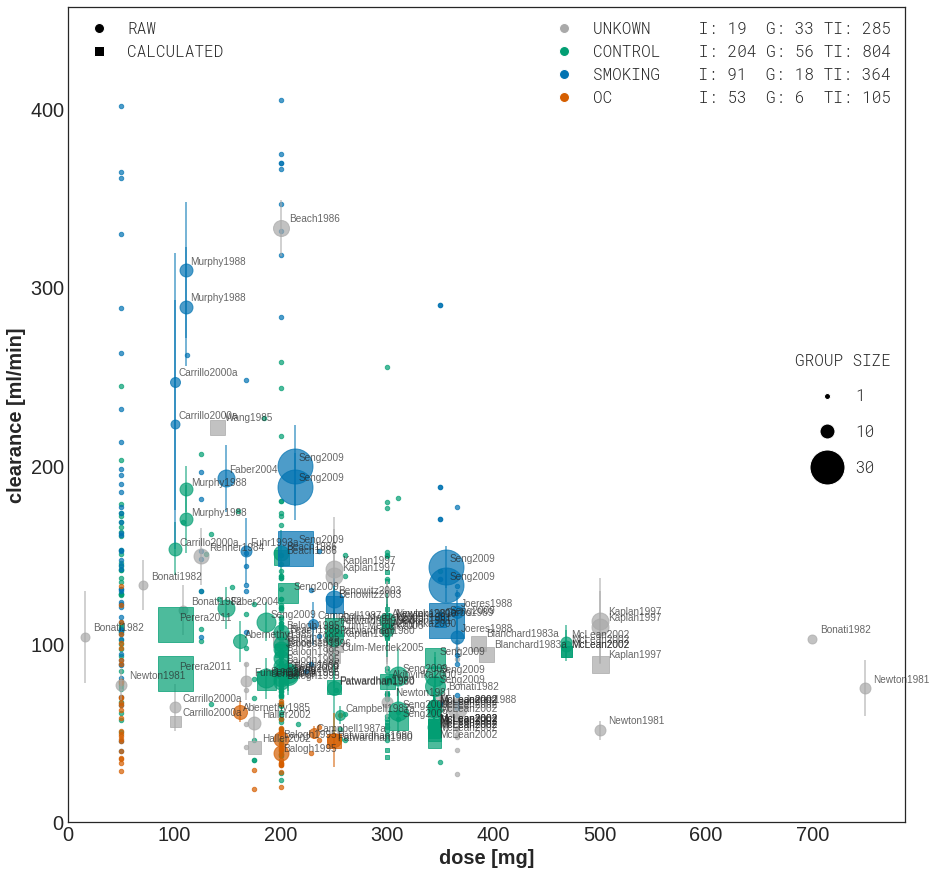

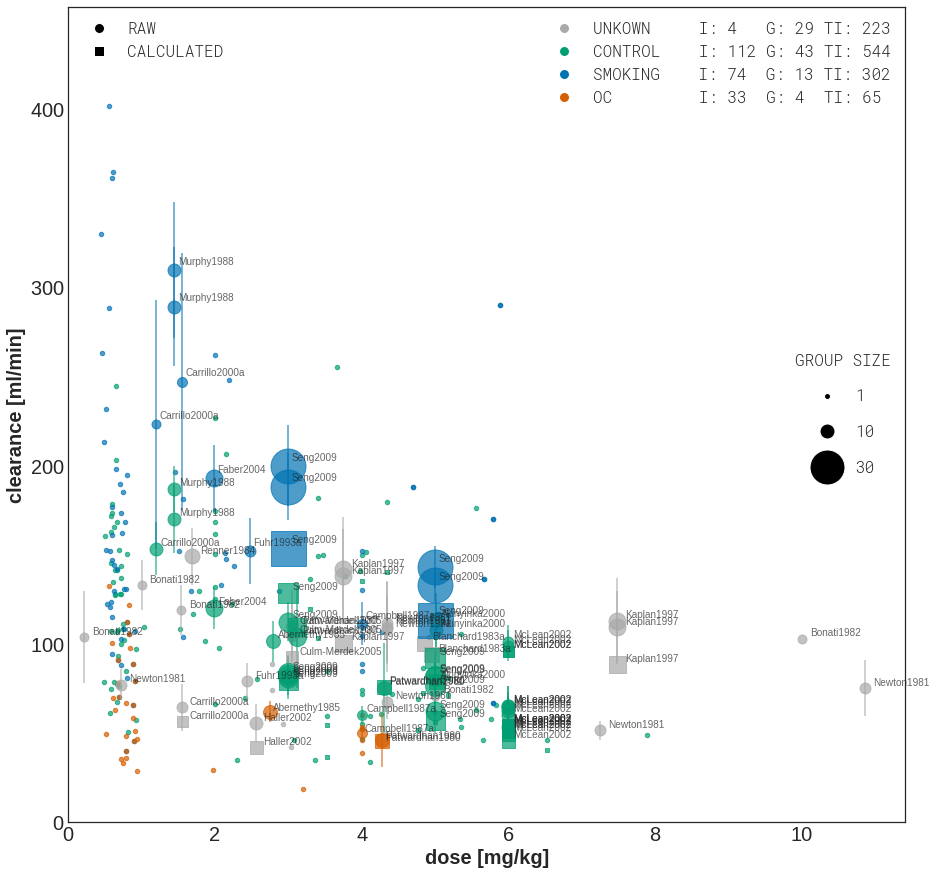

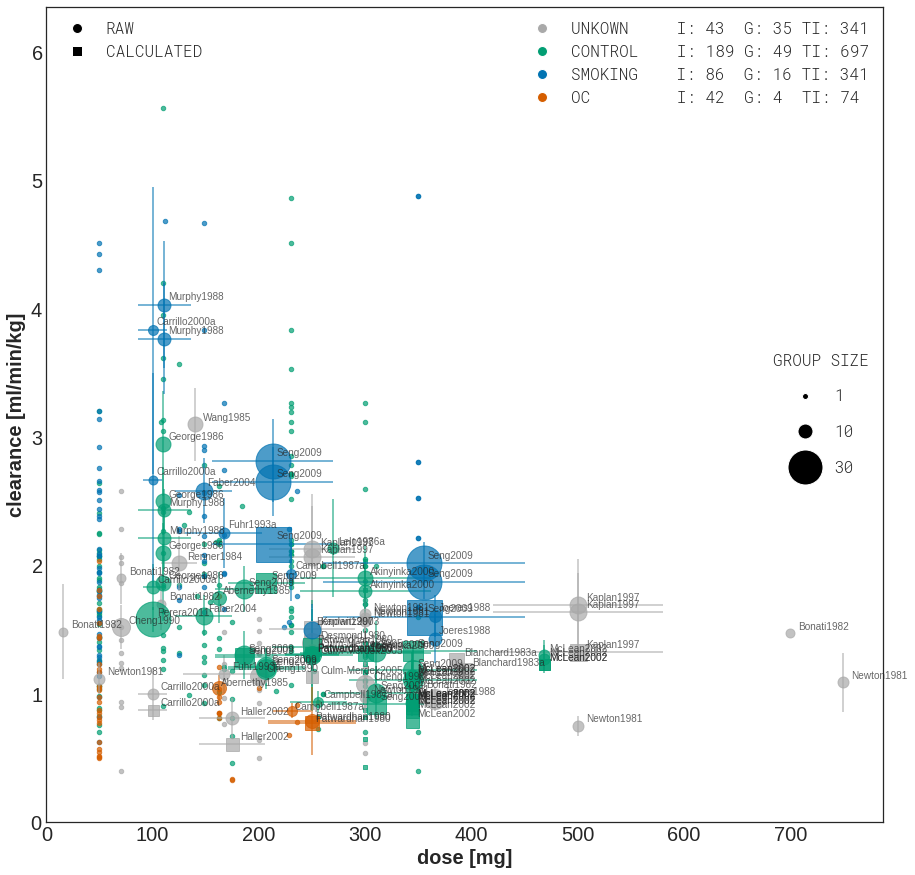

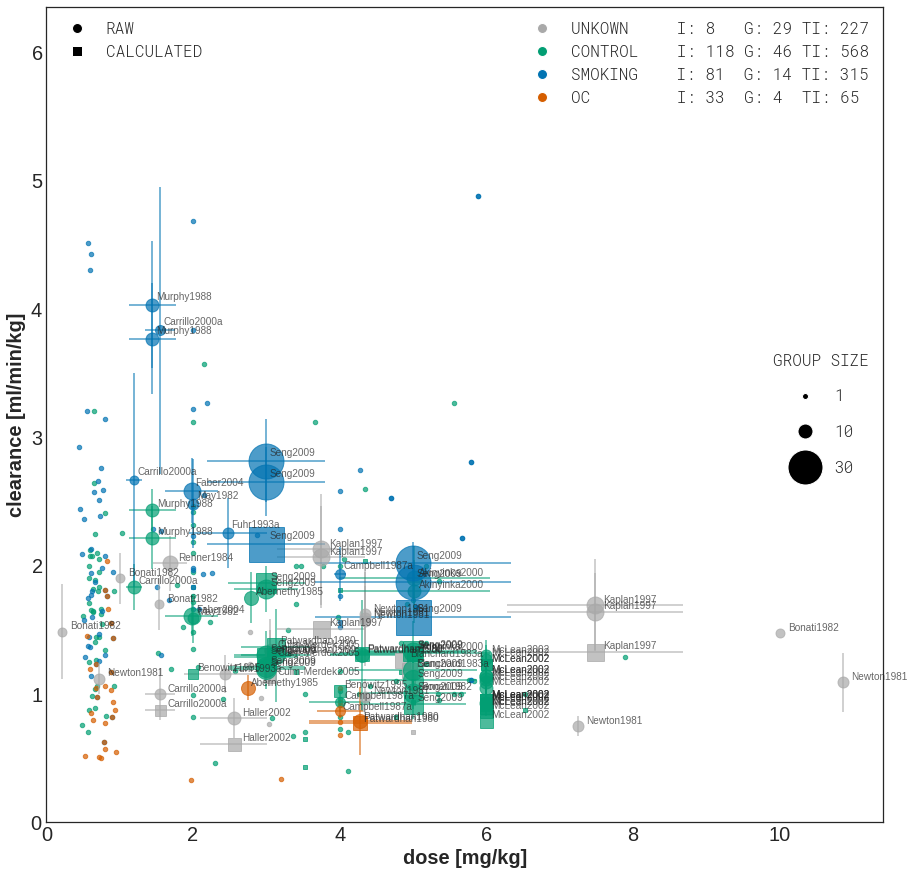

In [279]:
create_plots(caffeine_clearance,categories_soft,"reports/soft","clearance")

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 47  G: 42 TI: 387
CONTROL    I: 190 G: 51 TI: 746
SMOKING    I: 68  G: 14 TI: 311
OC         I: 44  G: 6  TI: 96 
OC-SMOKING I: 9   G: 0  TI: 9  
UNKOWN     I: 22  G: 37 TI: 307
CONTROL    I: 99  G: 38 TI: 487
SMOKING    I: 60  G: 10 TI: 266
OC         I: 24  G: 4  TI: 56 
OC-SMOKING I: 9   G: 0  TI: 9  
UNKOWN     I: 61  G: 44 TI: 433
CONTROL    I: 176 G: 44 TI: 640
SMOKING    I: 72  G: 12 TI: 297
OC         I: 33  G: 4  TI: 65 
OC-SMOKING I: 9   G: 0  TI: 9  
UNKOWN     I: 26  G: 37 TI: 311
CONTROL    I: 105 G: 41 TI: 511
SMOKING    I: 67  G: 11 TI: 279
OC         I: 24  G: 4  TI: 56 
OC-SMOKING I: 9   G: 0  TI: 9  


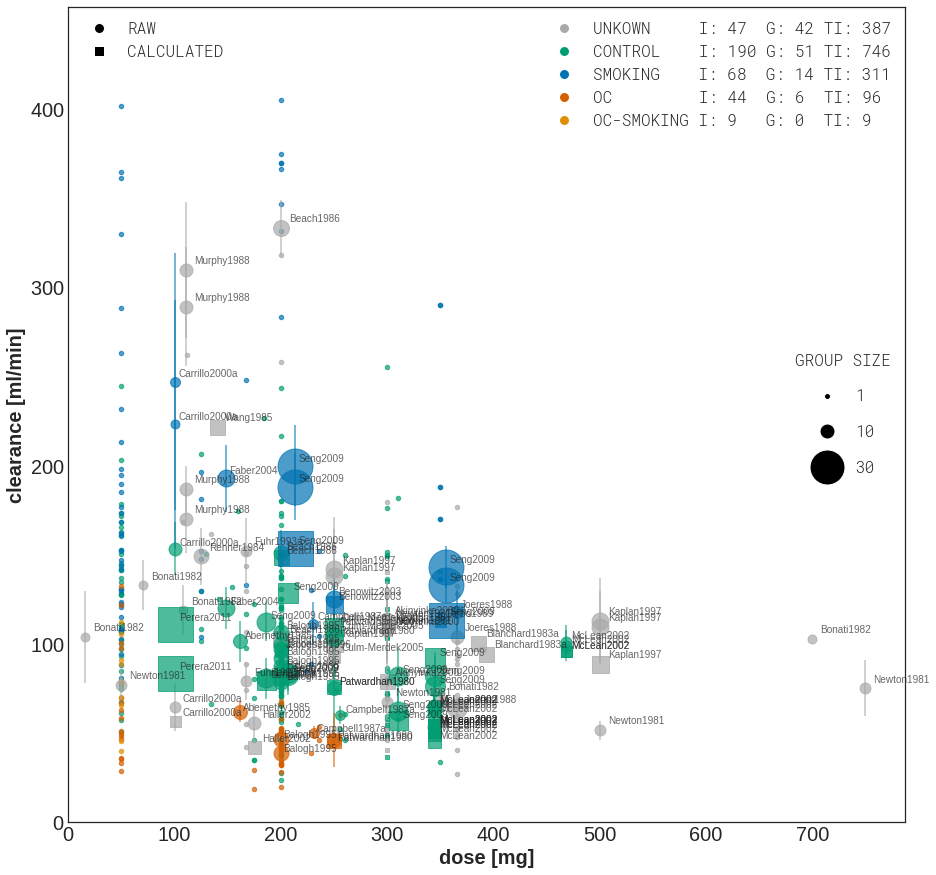

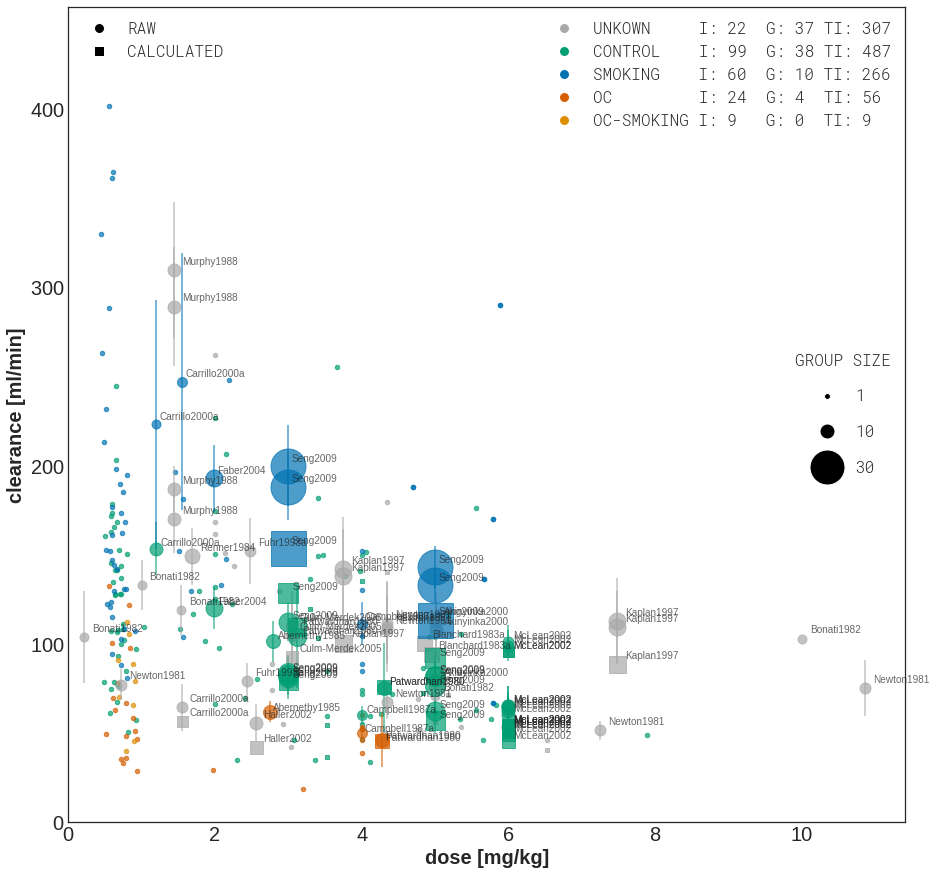

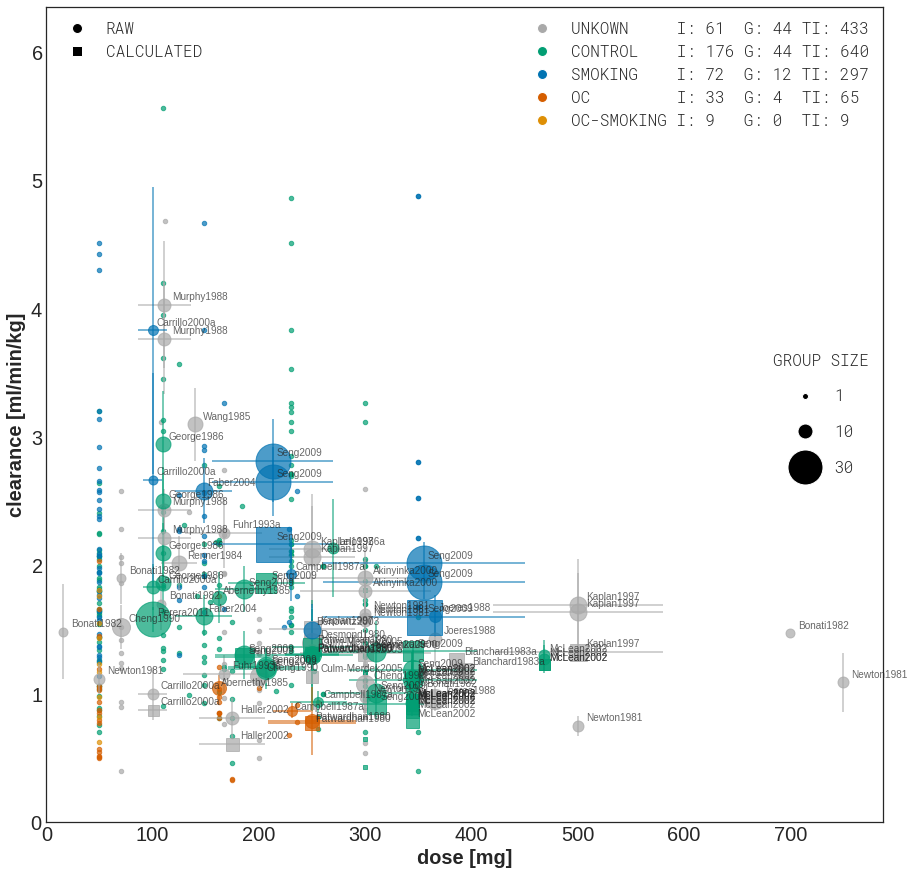

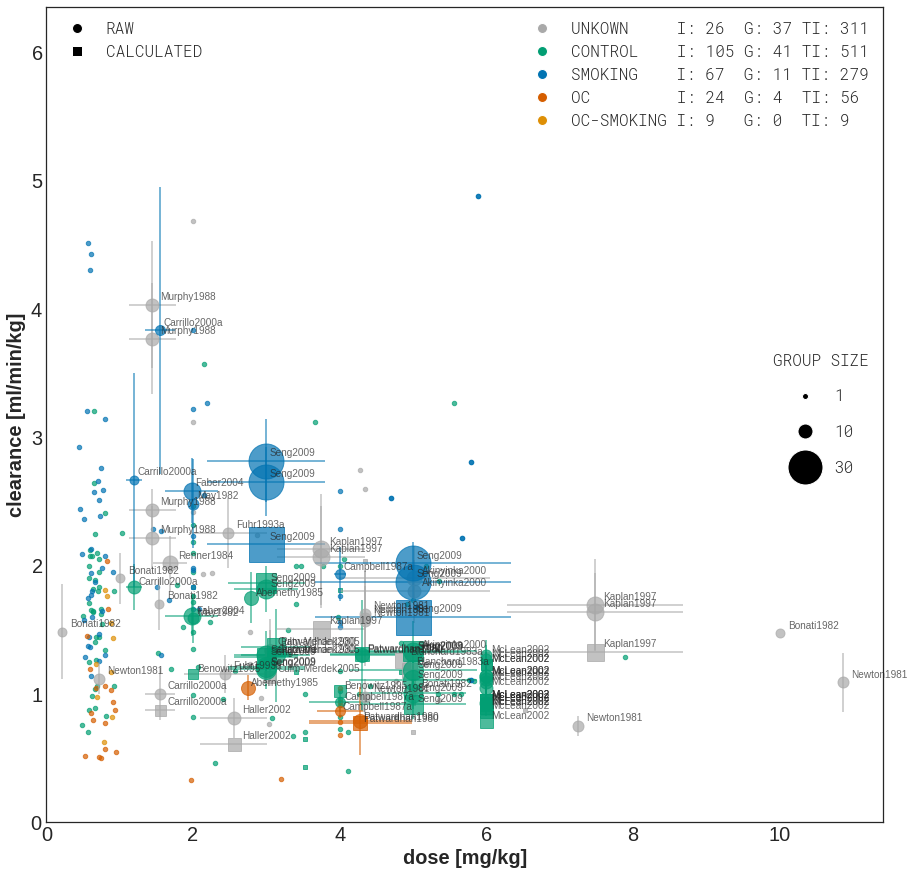

In [280]:
create_plots(caffeine_clearance,categories_strict,"reports/strict","clearance")

In [281]:
caffeine_clearance[abs_idx(caffeine_clearance,"unit_intervention") & abs_idx(caffeine_clearance,"unit")].groupby("subject_type").count()

study  output_type   pk  raw_pk  tissue  interventions  unit  \
subject_type                                                                 
group           124          124  124     124     124            124   124   
individual      502          502  502     502     502            502   502   

              substance_name  pktype  calculated  ...  \
subject_type                                      ...   
group                    124     124         124  ...   
individual               502     502         502  ...   

              (metabolic ratio, count)  (metabolic ratio, max)  \
subject_type                                                     
group                                0                       0   
individual                           0                       0   

              (metabolic ratio, mean)  (metabolic ratio, min)  \
subject_type                                                    
group                               0                       0   
individual                          0                       0   

              (metabolic ratio, unit)  (fat weight, count)  \
subject_type                                                 
group                               0                   18   
individual                          0                    0   

              (fat weight, mean)  (fat weight, se)  (fat weight, unit)  \
subject_type                                                             
group                         18                18                  18   
individual                     0                 0                   0   

              outlier  
subject_type           
group             124  
individual        502  

[2 rows x 252 columns]

In [282]:
caffeine_thf = PkdbModel("caffeine_thalf",destination="3-inferred")
caffeine_thf.read()
caffeine_thalf = caffeine_thf.data
caffeine_thalf["outlier"] = False
caffeine_thalf.loc[caffeine_thalf["study"]== "Balogh1992","outlier"] = True
caffeine_thalf.loc[caffeine_thalf["study"]== "Harder1988","outlier"] = True
caffeine_thalf.loc[caffeine_thalf["study"]== "Harder1989","outlier"] = True

In [283]:
caffeine_thalf.groupby(["calculated","outlier"]).get_group((True,False))[["study","value_intervention","unit_intervention","unit","value","mean"]]

study  value_intervention unit_intervention   unit  value  \
152     Akinyinka2000          300.000000                mg     hr    NaN   
184         Beach1986          200.000000                mg     hr    NaN   
186         Beach1986          200.000000                mg     hr    NaN   
187         Carbo1989          350.000000                mg     hr    NaN   
200      Benowitz2003          250.000000                mg     hr    NaN   
207        Bonati1982            5.000000             mg/kg     hr   5.31   
208        Bonati1982            5.000000             mg/kg     hr   4.40   
209        Bonati1982            5.000000             mg/kg     hr   6.79   
210        Bonati1982            5.000000             mg/kg     hr   9.59   
225    Blanchard1983a            4.940000             mg/kg     hr    NaN   
226    Blanchard1983a            4.850000             mg/kg     hr    NaN   
227      Benowitz1995            2.000000             mg/kg     hr    NaN   
228      Benowitz1995            4.000000             mg/kg     hr    NaN   
234     Carrillo2000a          100.000000                mg     hr    NaN   
251   Culm-Merdek2005          250.000000                mg     hr    NaN   
269        Haller2002          175.000000                mg     hr    NaN   
273        Kaplan1997          500.000000                mg     hr    NaN   
275        Kaplan1997          250.000000                mg     hr    NaN   
277      Jeppesen1996          200.000000                mg     hr    NaN   
285           May1982            2.000000             mg/kg     hr   2.93   
289        McLean2002            6.000000             mg/kg     hr    NaN   
290        McLean2002            6.000000             mg/kg     hr    NaN   
291        McLean2002            6.000000             mg/kg     hr    NaN   
293        McLean2002            6.000000             mg/kg     hr    NaN   
294        McLean2002            6.000000             mg/kg     hr    NaN   
295        McLean2002            6.000000             mg/kg     hr    NaN   
296        McLean2002            6.000000             mg/kg     hr    NaN   
299        McLean2002            6.000000             mg/kg     hr    NaN   
301        McLean2002            6.000000             mg/kg     hr    NaN   
303        McLean2002            6.000000             mg/kg     hr    NaN   
...               ...                 ...               ...    ...    ...   
1836   Patwardhan1980          250.000000                mg  hr/kg    NaN   
1838   Patwardhan1980          250.000000                mg  hr/kg    NaN   
1842   Patwardhan1980          250.000000                mg  hr/kg    NaN   
1848    Akinyinka2000            5.016722             mg/kg  hr/kg    NaN   
1853    Carrillo2000a            1.550388             mg/kg  hr/kg    NaN   
1859  Culm-Merdek2005            3.048780             mg/kg  hr/kg    NaN   
1869       Haller2002            2.554745             mg/kg  hr/kg    NaN   
1873       Kaplan1997            7.485030             mg/kg  hr/kg    NaN   
1875       Kaplan1997            3.742515             mg/kg  hr/kg    NaN   
1885   Patwardhan1980            4.310345             mg/kg  hr/kg    NaN   
1887   Patwardhan1980            4.280822             mg/kg  hr/kg    NaN   
1890   Patwardhan1980            3.125000             mg/kg  hr/kg    NaN   
1902   Blanchard1983a          392.730000                mg  hr/kg    NaN   
1903   Blanchard1983a          385.575000                mg  hr/kg    NaN   
1907       McLean2002          344.400000                mg  hr/kg    NaN   
1908       McLean2002          344.400000                mg  hr/kg    NaN   
1909       McLean2002          344.400000                mg  hr/kg    NaN   
1911       McLean2002          344.400000                mg  hr/kg    NaN   
1912       McLean2002          344.400000                mg  hr/kg    NaN   
1913       McLean2002          344.400000                mg  hr/kg    NaN   
1914       M

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 24  G: 40 TI: 369
CONTROL    I: 175 G: 54 TI: 763
SMOKING    I: 68  G: 11 TI: 239
OC         I: 33  G: 6  TI: 85 
OC-SMOKING I: 9   G: 0  TI: 9  
UNKOWN     I: 26  G: 31 TI: 262
CONTROL    I: 105 G: 38 TI: 467
SMOKING    I: 67  G: 8  TI: 207
OC         I: 24  G: 4  TI: 56 
OC-SMOKING I: 9   G: 0  TI: 9  
UNKOWN     I: 22  G: 31 TI: 258
CONTROL    I: 99  G: 35 TI: 443
SMOKING    I: 60  G: 7  TI: 194
OC         I: 24  G: 4  TI: 56 
OC-SMOKING I: 9   G: 0  TI: 9  
UNKOWN     I: 22  G: 31 TI: 258
CONTROL    I: 99  G: 35 TI: 443
SMOKING    I: 60  G: 7  TI: 194
OC         I: 24  G: 4  TI: 56 
OC-SMOKING I: 9   G: 0  TI: 9  


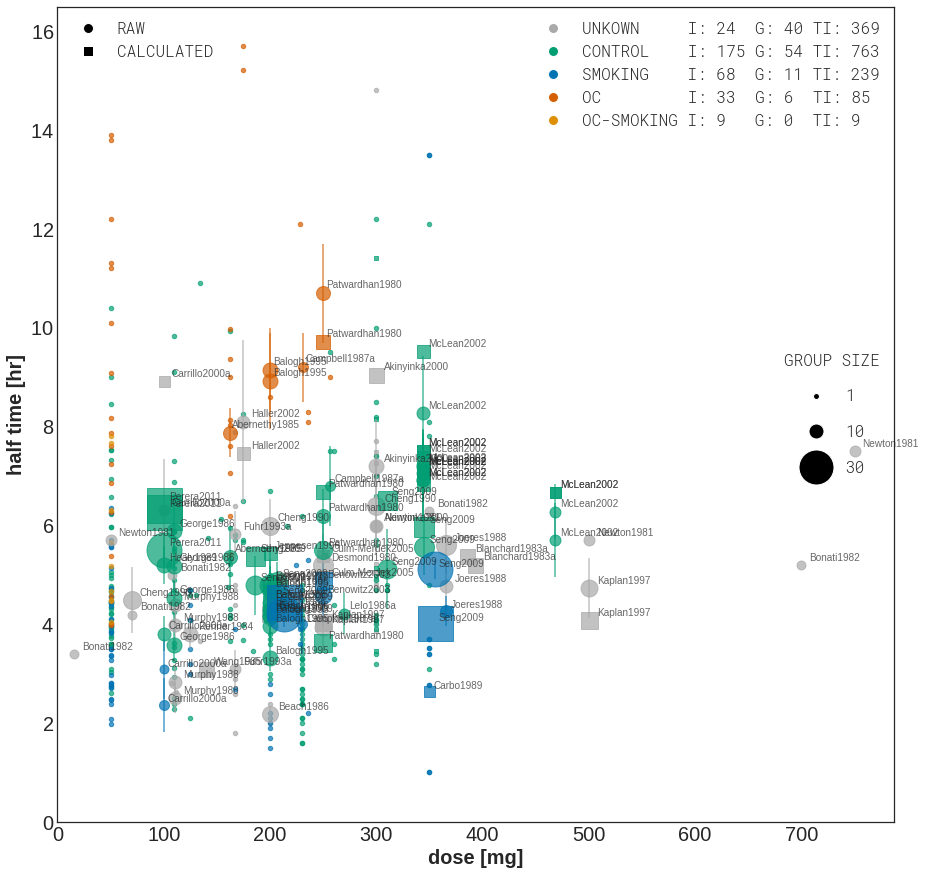

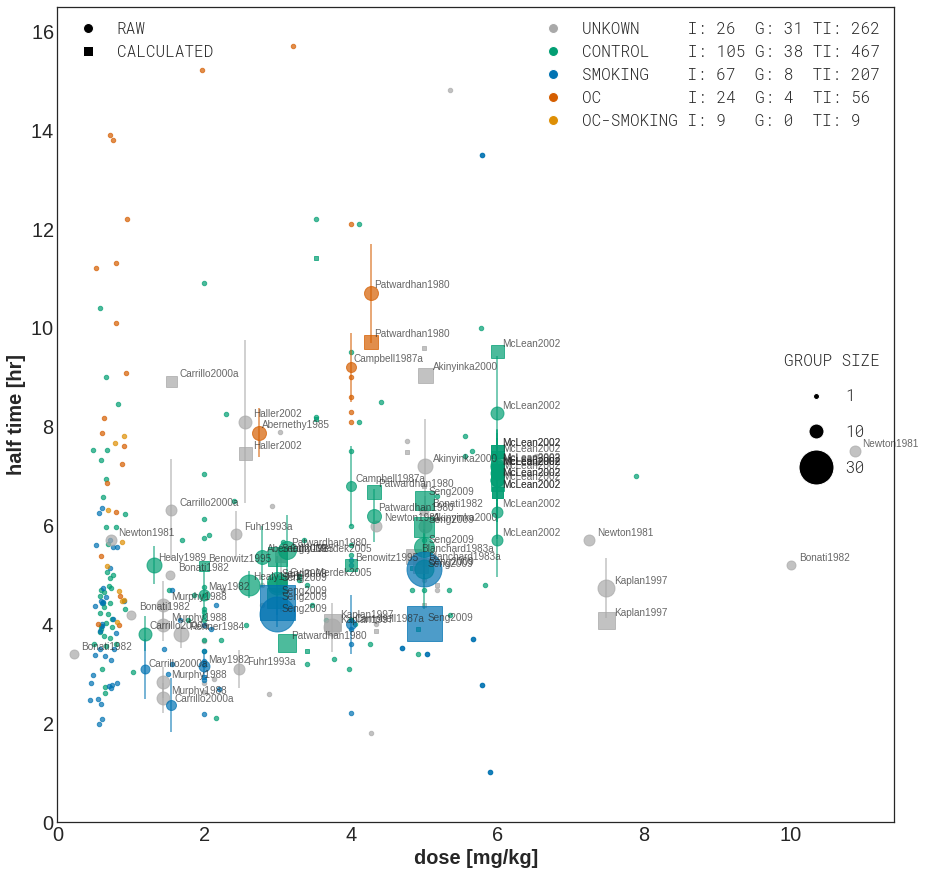

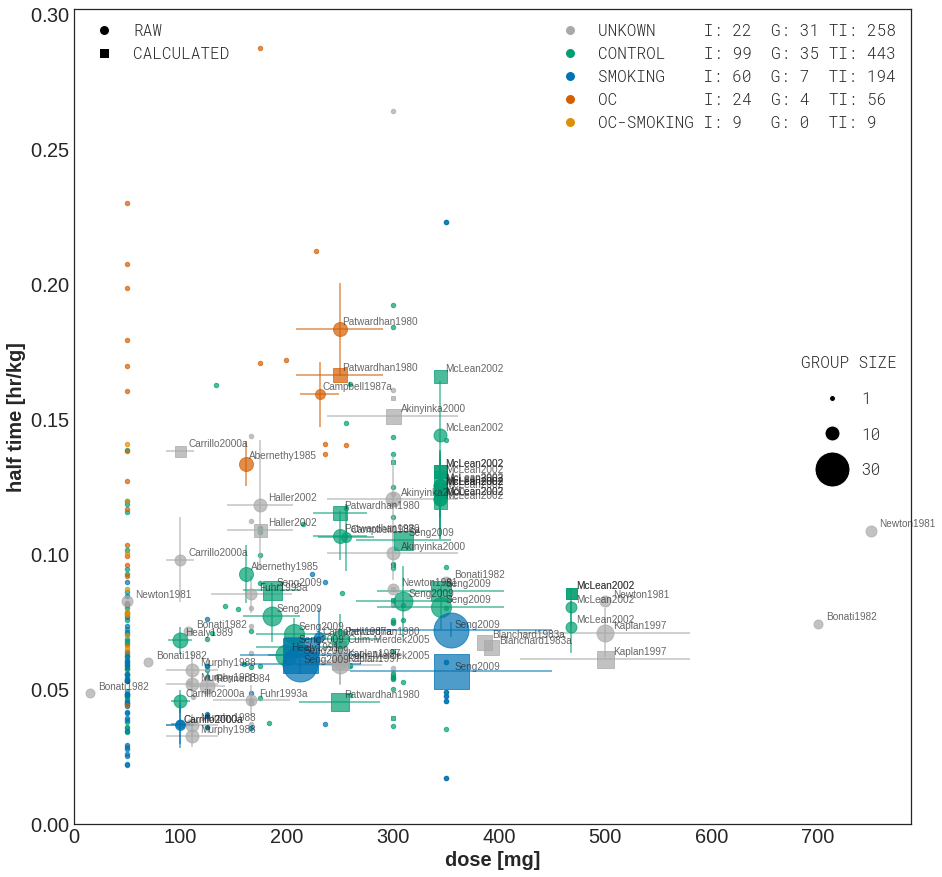

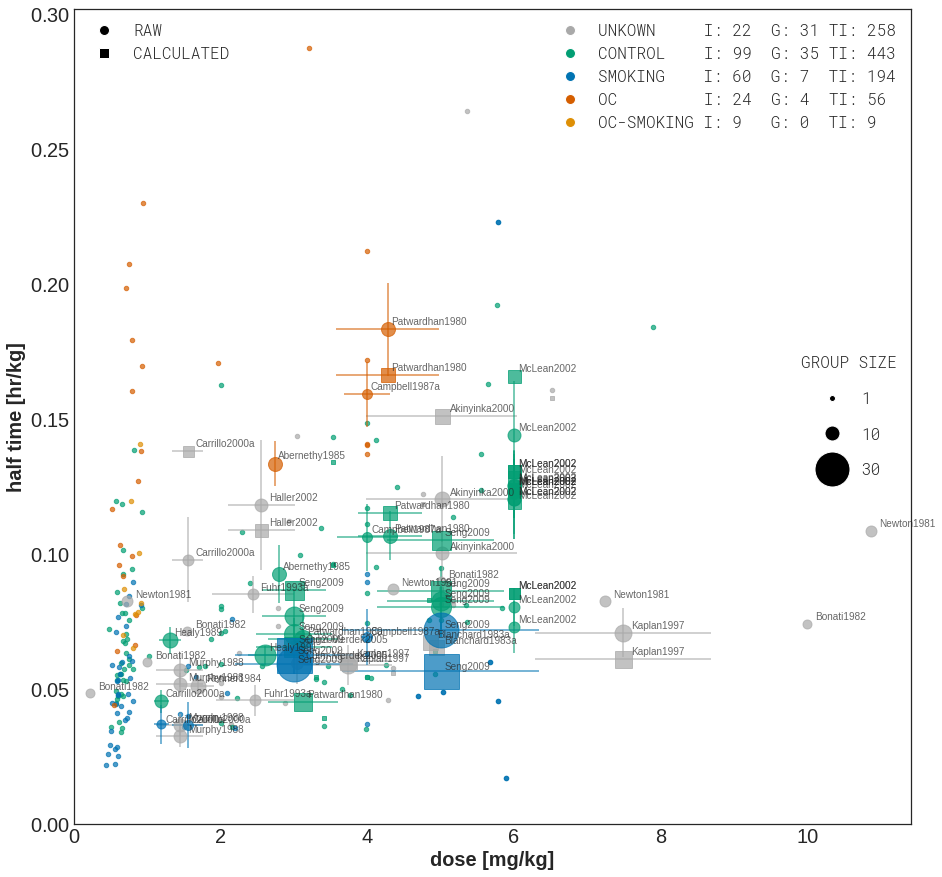

In [284]:
create_plots(caffeine_thalf,categories_strict,"reports/strict","thalf")

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:27: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


UNKOWN     I: 4   G: 31 TI: 275
CONTROL    I: 189 G: 59 TI: 821
SMOKING    I: 83  G: 15 TI: 284
OC         I: 42  G: 6  TI: 94 
UNKOWN     I: 8   G: 23 TI: 178
CONTROL    I: 118 G: 43 TI: 524
SMOKING    I: 81  G: 11 TI: 243
OC         I: 33  G: 4  TI: 65 
UNKOWN     I: 4   G: 23 TI: 174
CONTROL    I: 112 G: 40 TI: 500
SMOKING    I: 74  G: 10 TI: 230
OC         I: 33  G: 4  TI: 65 
UNKOWN     I: 4   G: 23 TI: 174
CONTROL    I: 112 G: 40 TI: 500
SMOKING    I: 74  G: 10 TI: 230
OC         I: 33  G: 4  TI: 65 


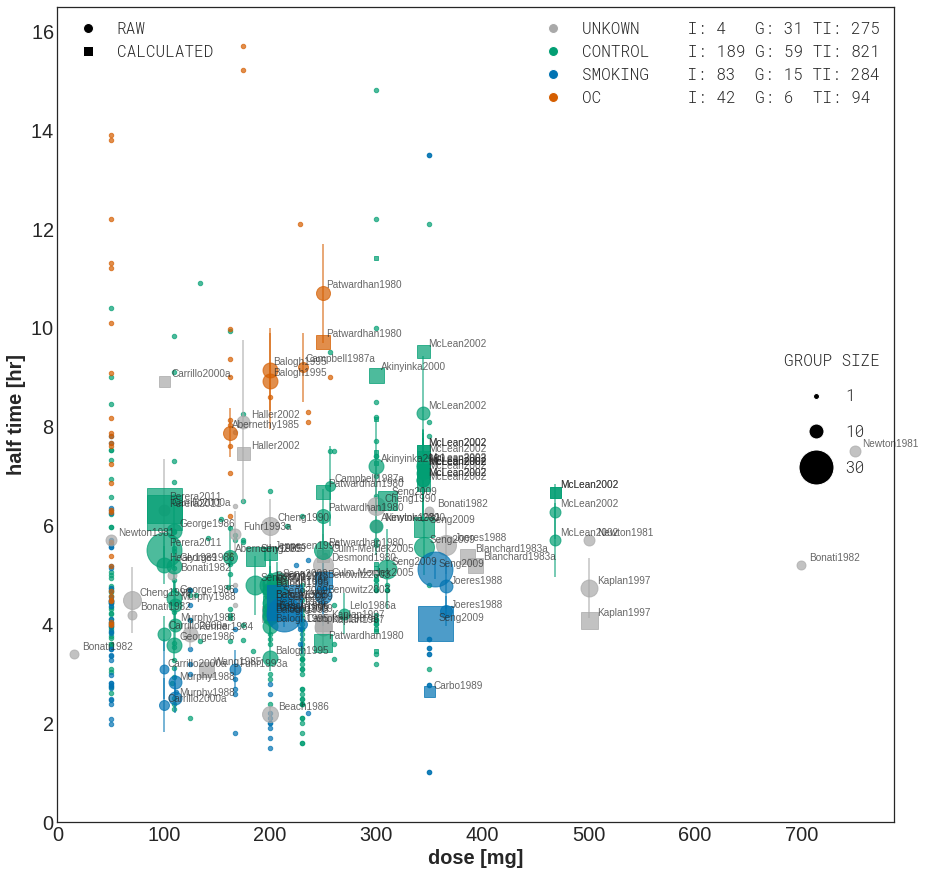

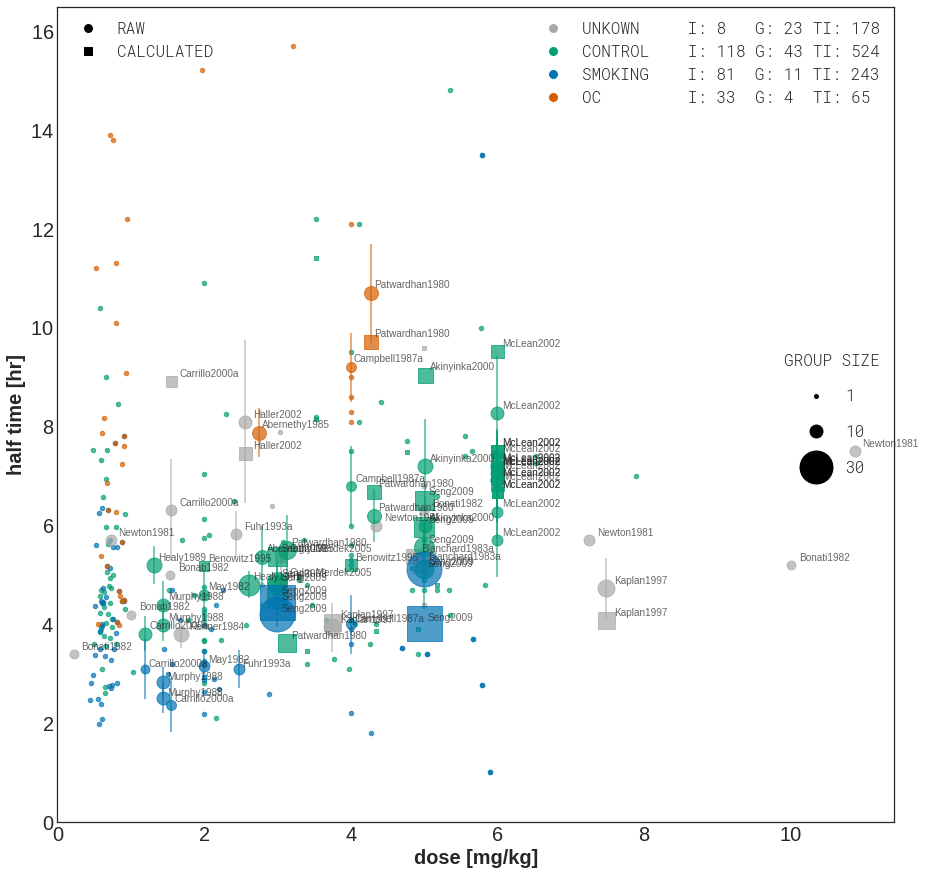

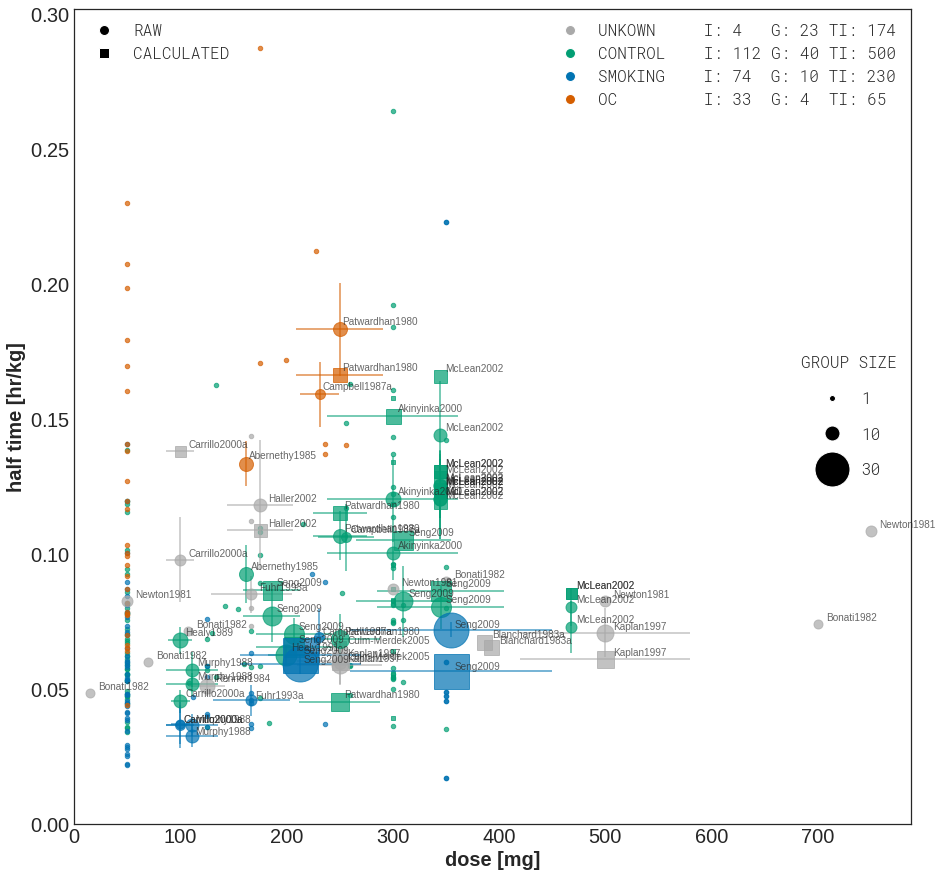

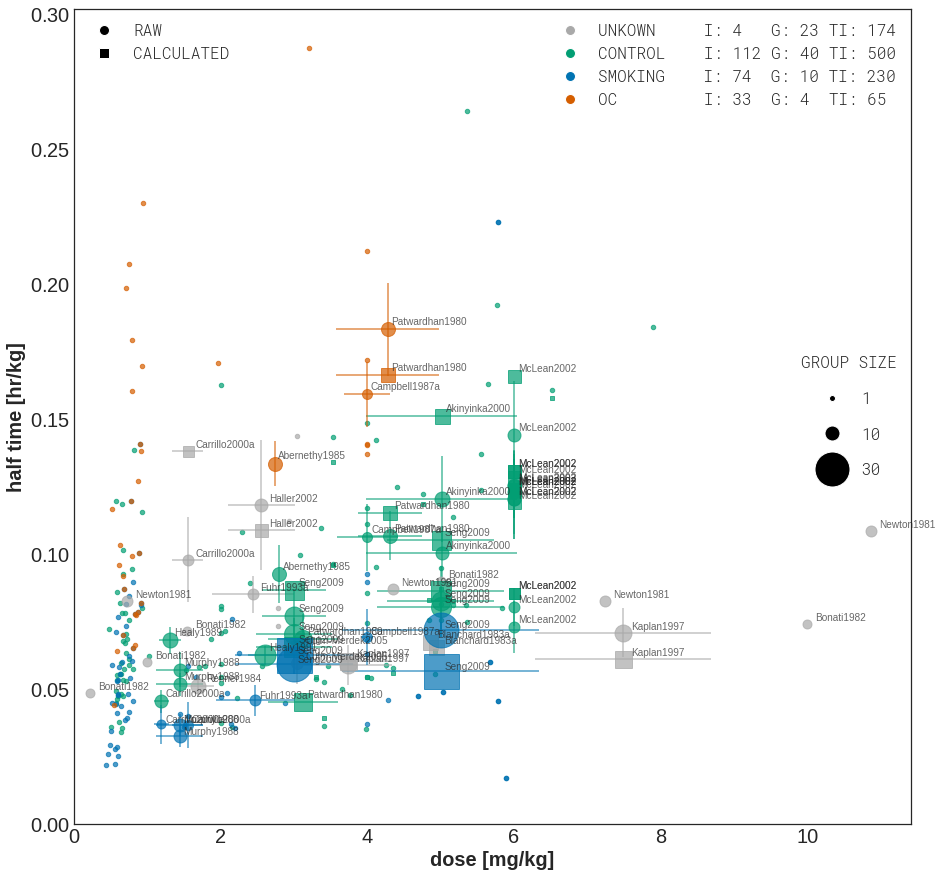

In [285]:
create_plots(caffeine_thalf,categories_soft,"reports/soft","thalf")

In [286]:
caffeine_mx = PkdbModel("caffeine_tmax",destination="3-inferred")
caffeine_mx.read()
caffeine_max = caffeine_mx.data
caffeine_max["outlier"] = False
caffeine_max.loc[caffeine_max["study"]== "Balogh1992","outlier"] = True
caffeine_max.loc[caffeine_max["study"]== "Harder1988","outlier"] = True
caffeine_max.loc[caffeine_max["study"]== "Harder1989","outlier"] = True

UNKOWN     I: 2   G: 33 TI: 305


AssertionError: ['hour' 'hour / kilogram']

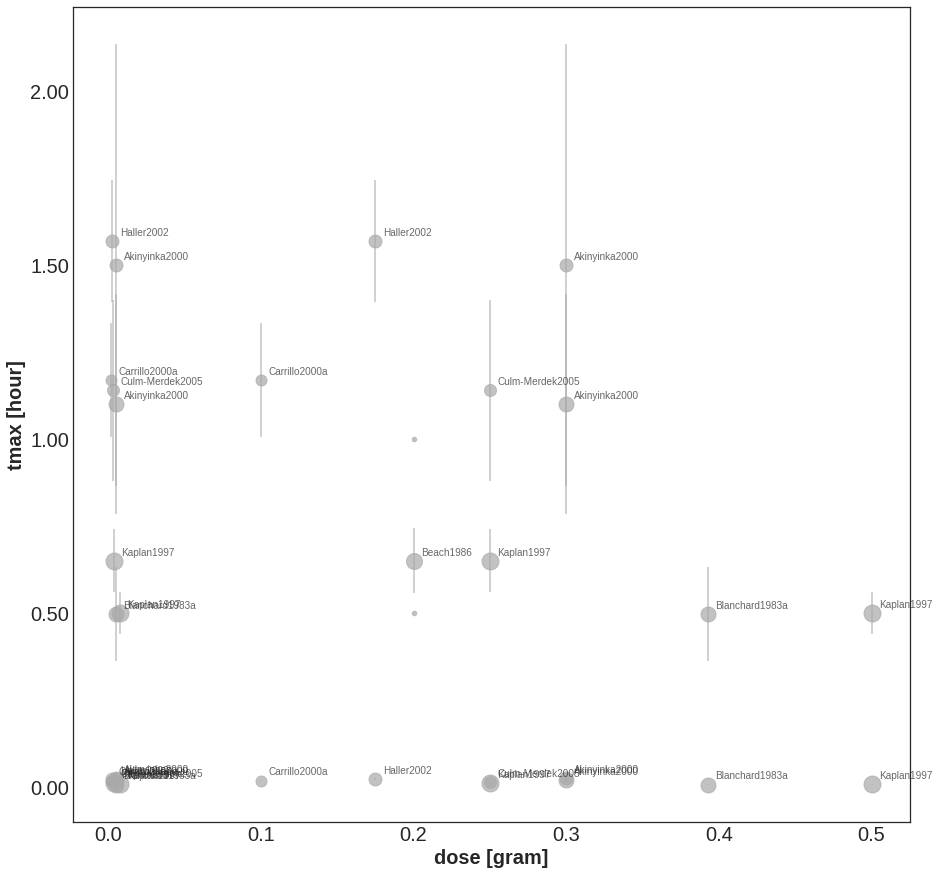

In [287]:
create_plots(caffeine_max,categories_strict,"reports/strict","tmax")

In [ ]:
create_plots(caffeine_max,categories_soft,"reports/soft","tmax")

In [ ]:
caffeine_instance = PkdbModel("caffeine_vd",destination="3-inferred")
caffeine_instance.read()
caffeine_instance_data = caffeine_instance.data
caffeine_instance_data["outlier"] = False
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Balogh1992","outlier"] = True
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Harder1988","outlier"] = True
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Harder1989","outlier"] = True

In [ ]:
create_plots(caffeine_instance_data,categories_strict,"reports/strict","vd")
create_plots(caffeine_instance_data,categories_soft,"reports/soft","vd")

In [ ]:
caffeine_instance = PkdbModel("caffeine_auc_inf",destination="3-inferred")
caffeine_instance.read()
caffeine_instance_data = caffeine_instance.data
caffeine_instance_data["outlier"] = False
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Balogh1992","outlier"] = True
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Harder1988","outlier"] = True
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Harder1989","outlier"] = True
caffeine_instance_data.dropna(subset=["value"], inplace=True)

In [28]:
#intermediate = caffeine_instance_data[(caffeine_instance_data["value"].isna() == False)]
#intermediate[intermediate["calculated"]==True]

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:121: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


control I: 114 G: 0  TI: 114
smoking I: 49  G: 0  TI: 49 
oc      I: 17  G: 0  TI: 17 
oc-smoking I: 9   G: 0  TI: 9  
unknown I: 19  G: 0  TI: 19 
control I: 0   G: 0  TI: 0  
smoking I: 1   G: 0  TI: 1  
oc      I: 0   G: 0  TI: 0  
oc-smoking I: 0   G: 0  TI: 0  
unknown I: 4   G: 0  TI: 4  


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/matplotlib/ticker.py:2241: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:121: UserWarning: Attempted to set non-positive top ylim on a log-scaled axis.
Invalid limit will be ignored.


control I: 78  G: 0  TI: 78 
smoking I: 49  G: 0  TI: 49 
oc      I: 17  G: 0  TI: 17 
oc-smoking I: 9   G: 0  TI: 9  
unknown I: 19  G: 0  TI: 19 
control I: 125 G: 0  TI: 125
smoking I: 62  G: 0  TI: 62 
oc      I: 26  G: 0  TI: 26 
unknown I: 4   G: 0  TI: 4  
control I: 0   G: 0  TI: 0  
smoking I: 1   G: 0  TI: 1  
oc      I: 0   G: 0  TI: 0  
unknown I: 4   G: 0  TI: 4  
control I: 89  G: 0  TI: 89 
smoking I: 62  G: 0  TI: 62 
oc      I: 26  G: 0  TI: 26 
unknown I: 4   G: 0  TI: 4  


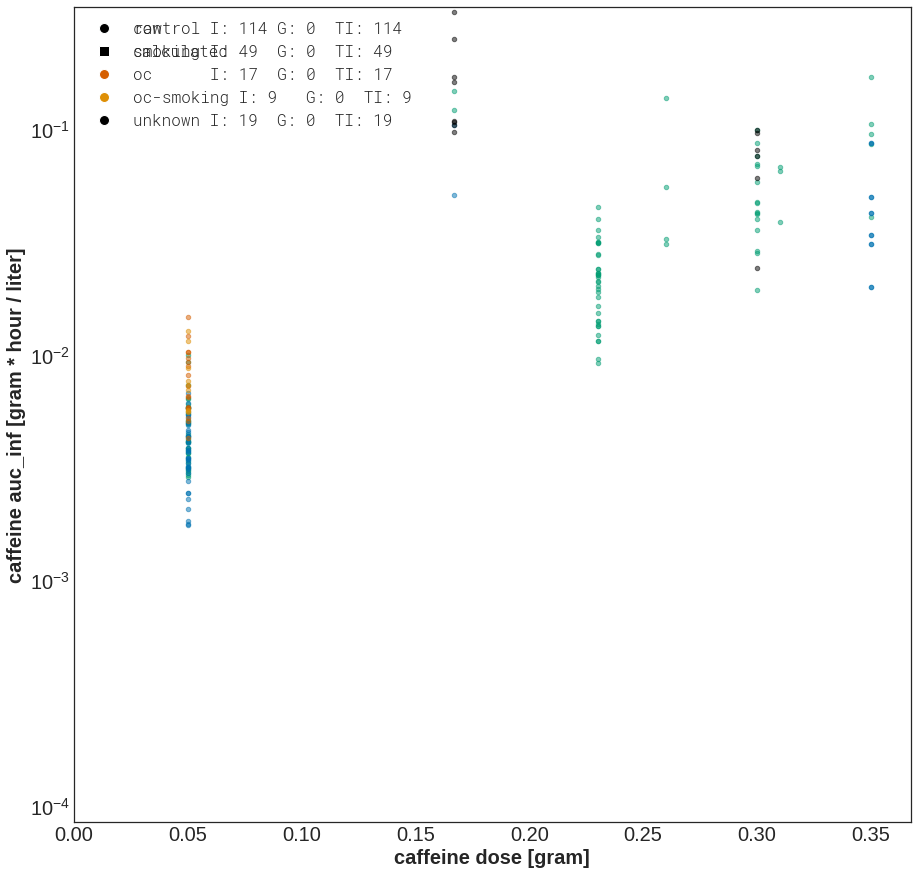

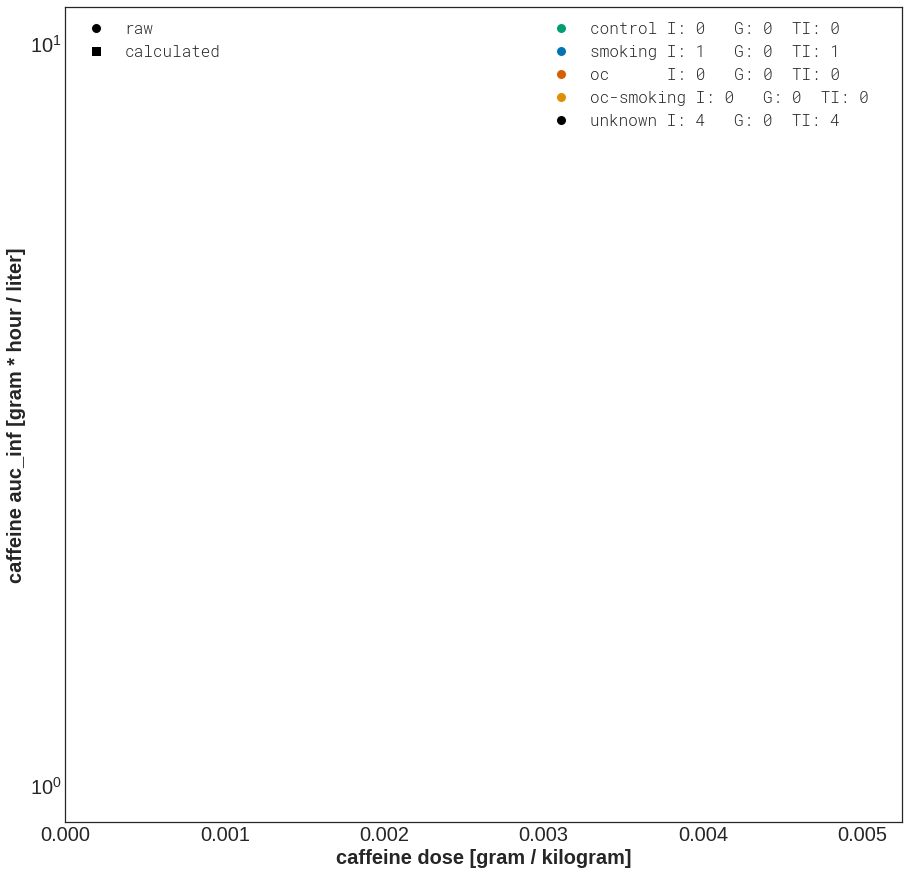

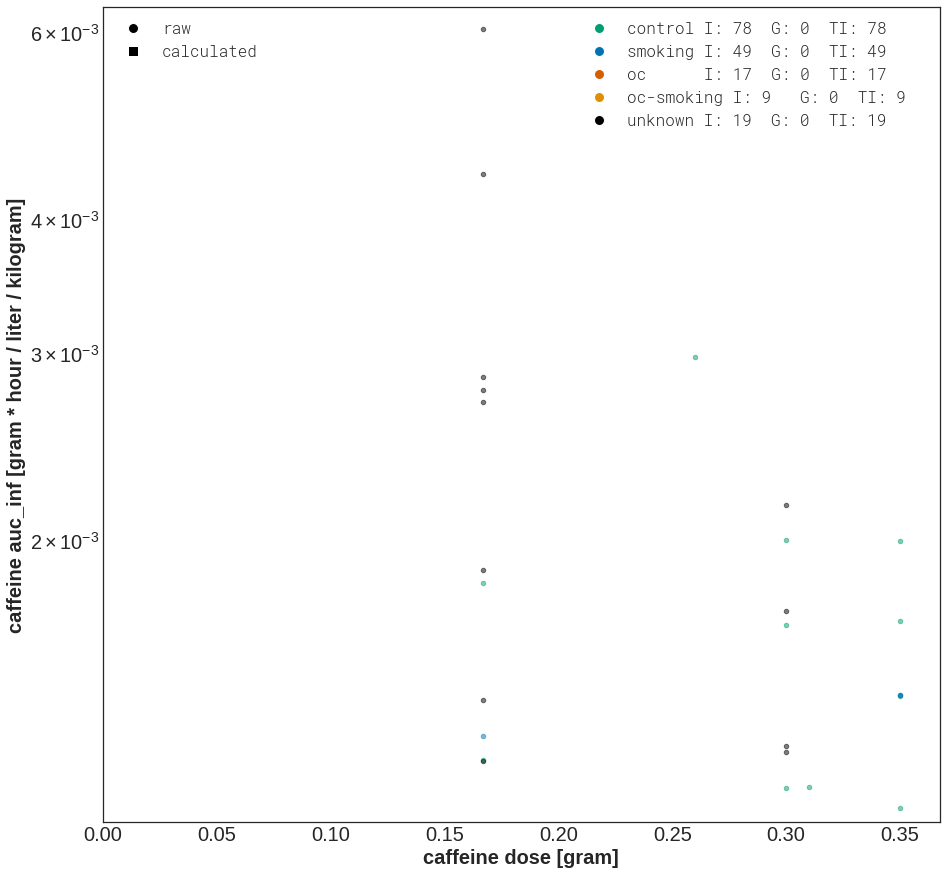

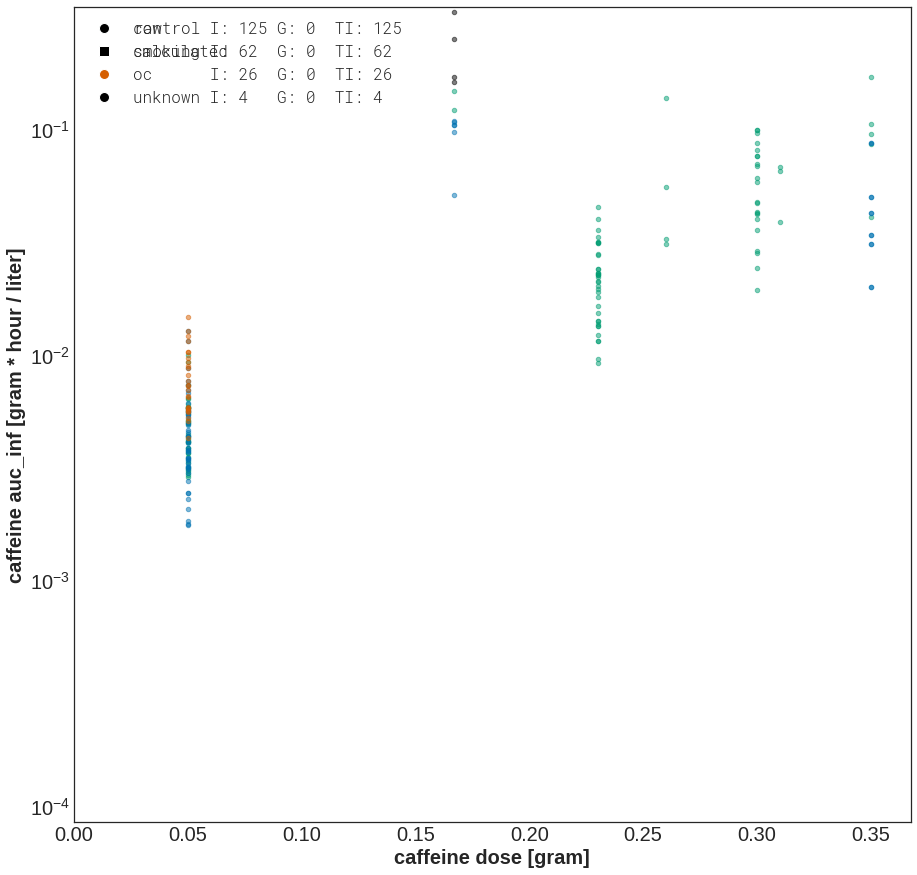

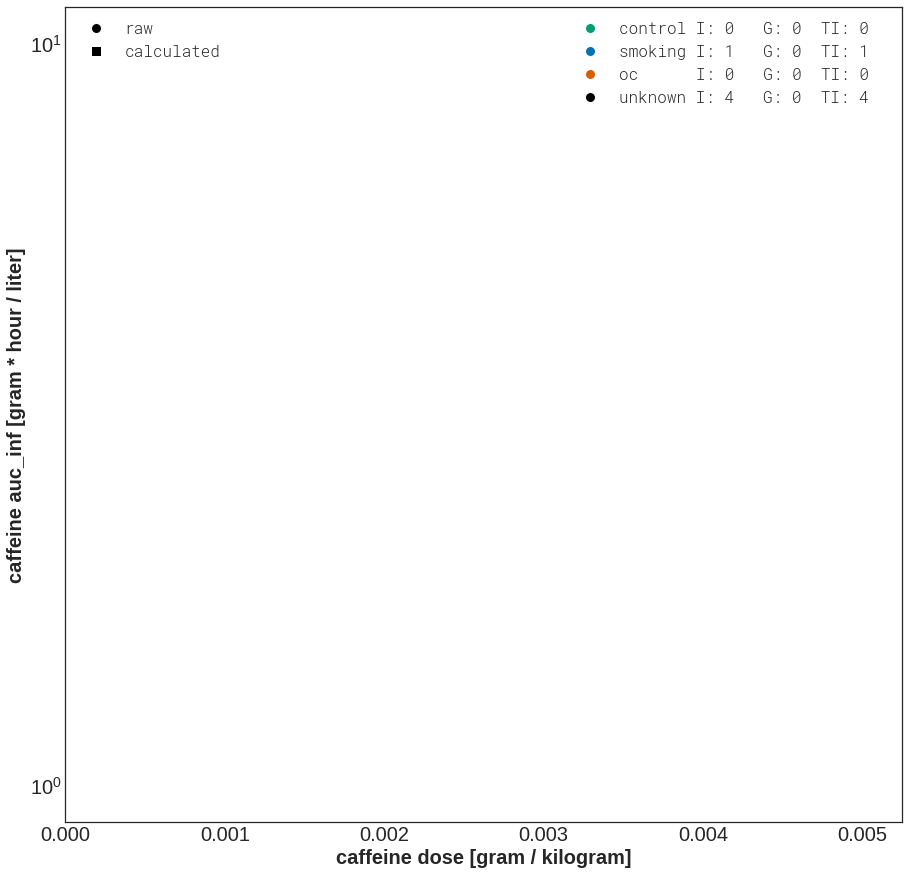

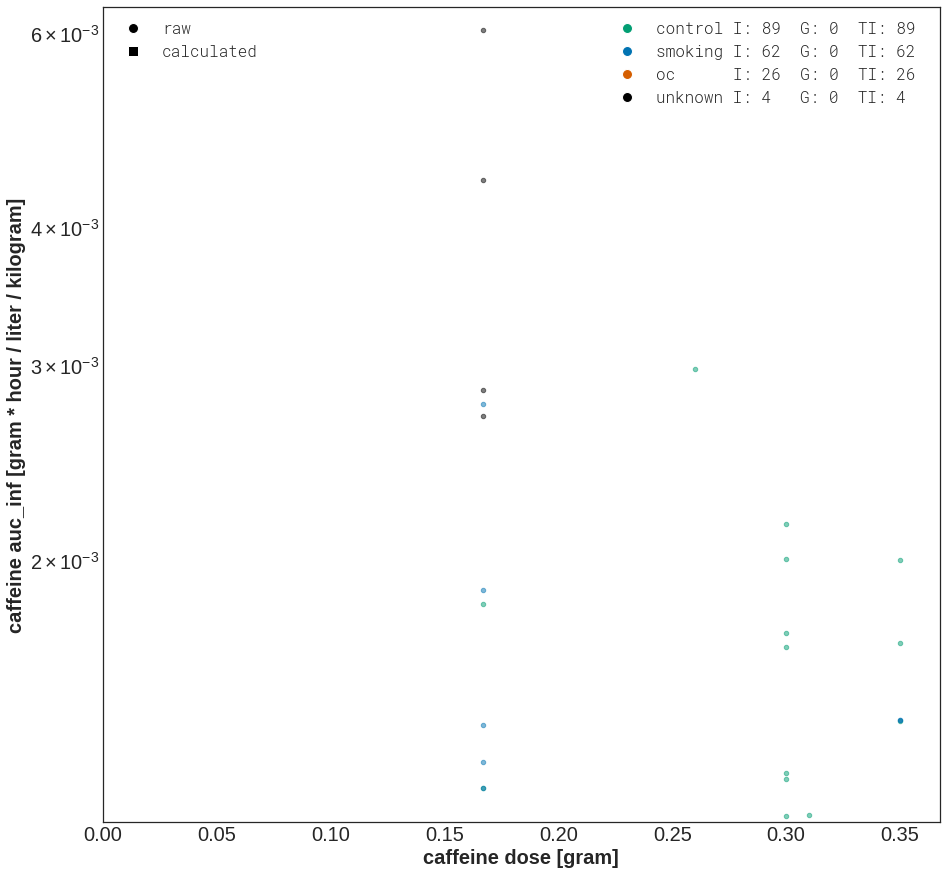

In [29]:
create_plots(caffeine_instance_data,categories_strict,"reports/strict","auc_inf", log_y=True)
create_plots(caffeine_instance_data,categories_soft,"reports/soft","auc_inf", log_y=True)

In [30]:
caffeine_instance = PkdbModel("caffeine_kel",destination="3-inferred")
caffeine_instance.read()
caffeine_instance_data = caffeine_instance.data
caffeine_instance_data["outlier"] = False
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Balogh1992","outlier"] = True
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Harder1988","outlier"] = True
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Harder1989","outlier"] = True

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/ipykernel_launcher.py:29: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


control I: 53  G: 30 TI: 362
smoking I: 40  G: 5  TI: 123
oc      I: 22  G: 2  TI: 36 
oc-smoking I: 9   G: 0  TI: 9  
unknown I: 5   G: 25 TI: 193
control I: 53  G: 28 TI: 296
smoking I: 41  G: 3  TI: 106
oc      I: 22  G: 2  TI: 36 
oc-smoking I: 9   G: 0  TI: 9  
unknown I: 9   G: 22 TI: 166
control I: 58  G: 31 TI: 377
smoking I: 49  G: 5  TI: 132
oc      I: 31  G: 2  TI: 45 
unknown I: 0   G: 24 TI: 178
control I: 58  G: 29 TI: 311
smoking I: 50  G: 3  TI: 115
oc      I: 31  G: 2  TI: 45 
unknown I: 4   G: 21 TI: 151


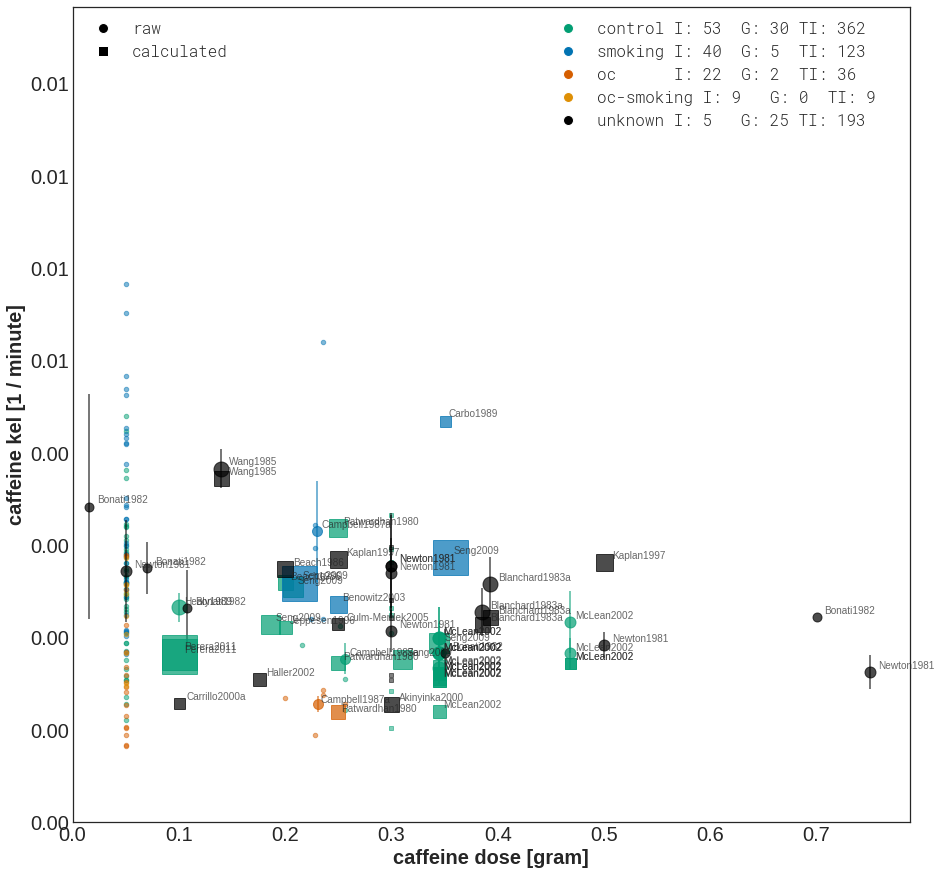

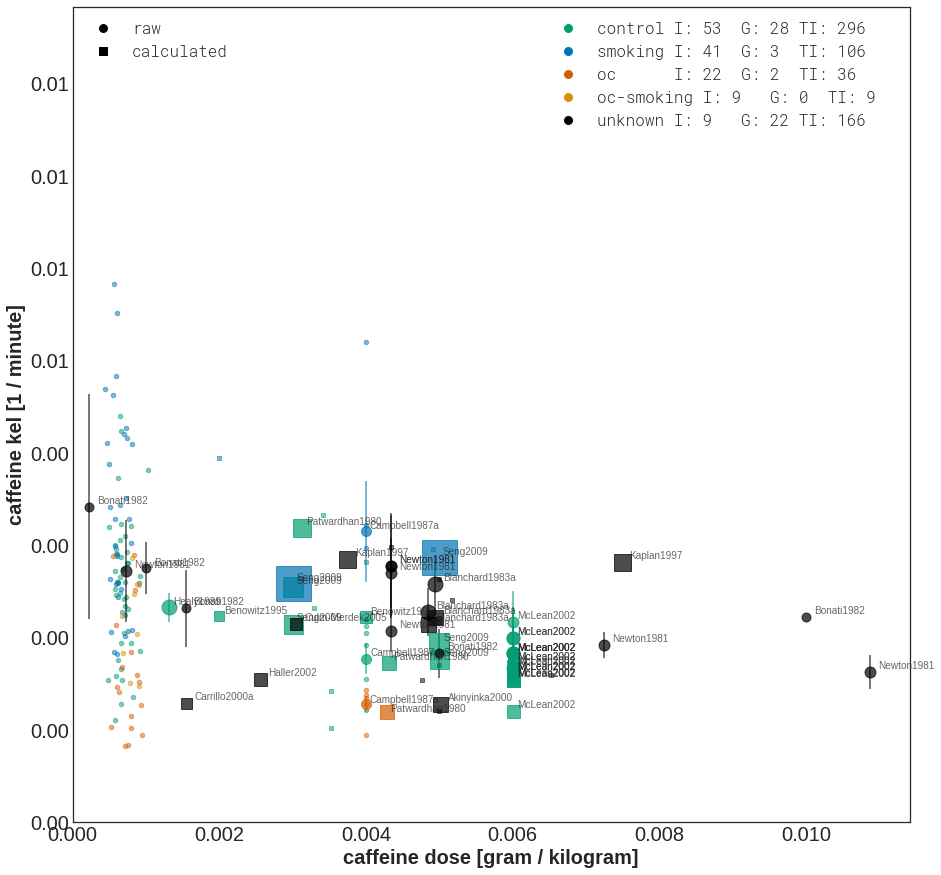

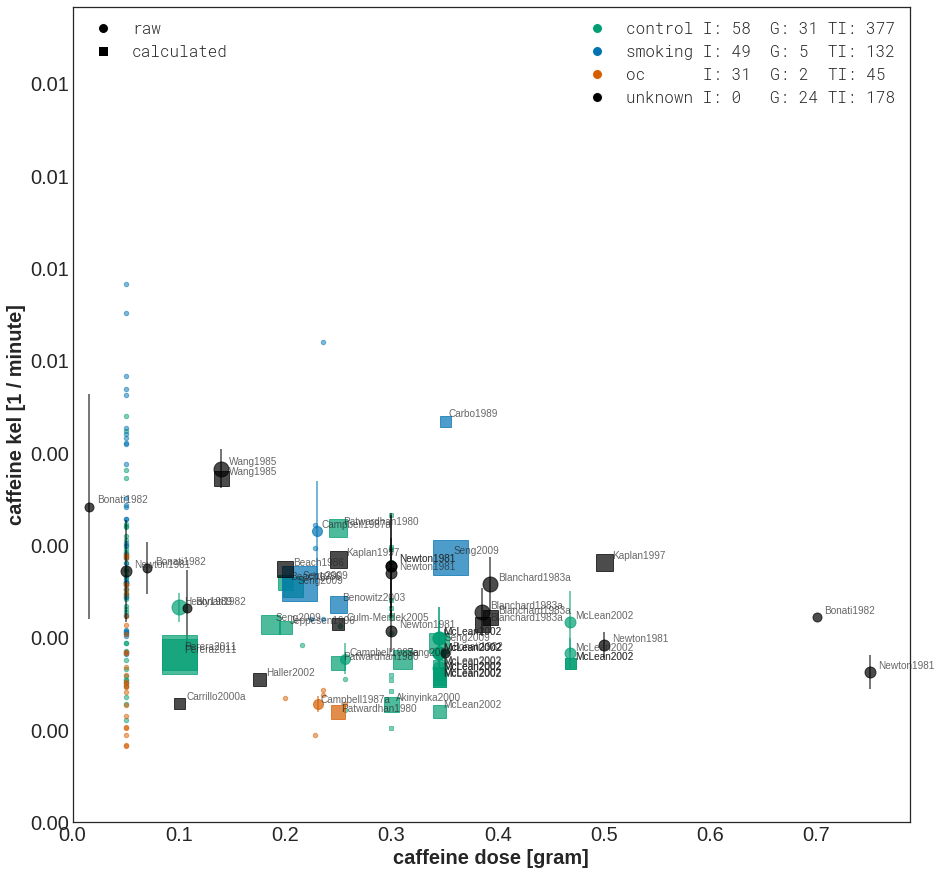

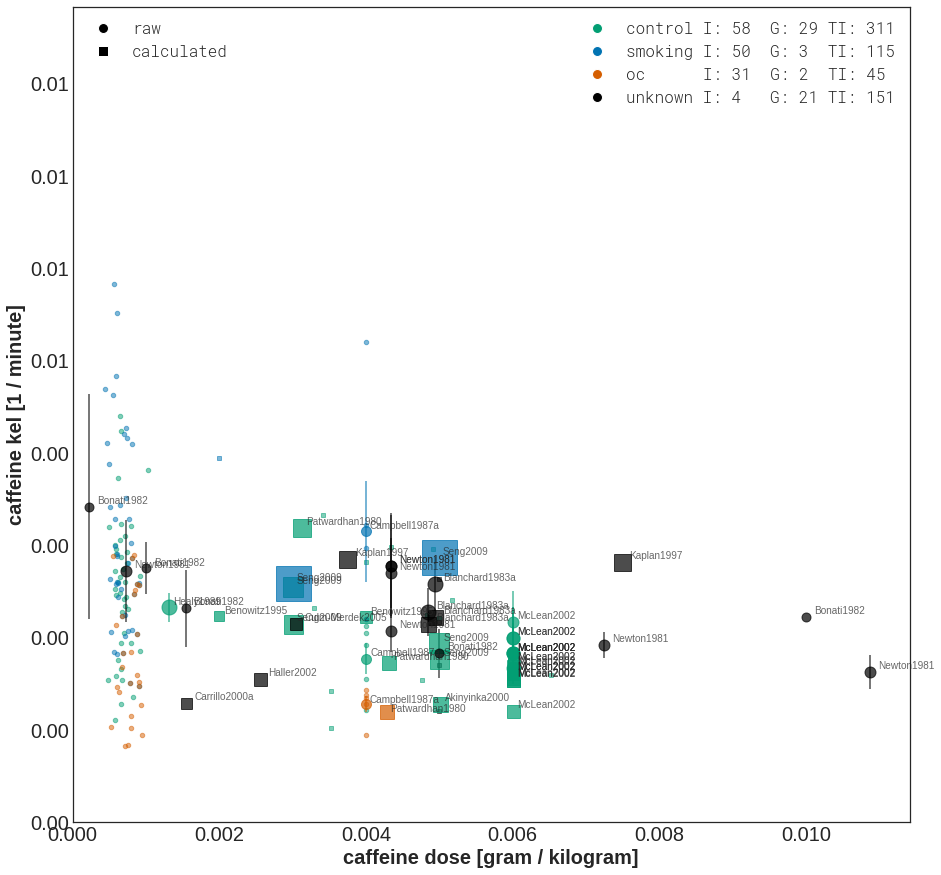

In [31]:
create_plots(caffeine_instance_data,categories_strict,"reports/strict","kel")
create_plots(caffeine_instance_data,categories_soft,"reports/soft","kel")

In [32]:
caffeine_thalf.dropna(axis=0, subset=["group_count"])[["mean", "group_count","sd","se","cv","unit"]]

mean  group_count        sd        se     cv             unit
151   7.200000         10.0  3.000000  0.949000  0.417             hour
152   9.050000         10.0       NaN       NaN    NaN             hour
153   6.000000          8.0  1.700000  0.601000  0.283             hour
154   4.700000         10.0  1.520000  0.481000  0.323             hour
155   4.660000         10.0  2.110000  0.667000  0.453             hour
156   4.440000         10.0  1.480000  0.468000  0.333             hour
157   4.820000         10.0  2.410000  0.762000  0.500             hour
158   3.320000         10.0  0.840000  0.266000  0.253             hour
159   3.960000         10.0  1.210000  0.383000  0.306             hour
160   4.150000         10.0  1.590000  0.503000  0.383             hour
161   4.190000         10.0  1.260000  0.398000  0.301             hour
162   9.150000         10.0  2.650000  0.838000  0.290             hour
167   5.370000          9.0       NaN  0.620000  0.346             hour
183   4.300000         10.0  1.020000  0.323000  0.237             hour
184   4.440000         10.0       NaN       NaN    NaN             hour
185   2.190000         11.0  0.440000  0.133000  0.201             hour
186   4.220000         11.0       NaN       NaN    NaN             hour
187   2.650000          6.0       NaN       NaN    NaN             hour
200   4.900000         12.0       NaN       NaN    NaN             hour
201   4.600000         12.0  2.200000  0.635000  0.478             hour
202   5.200000          4.0       NaN       NaN    NaN             hour
203   6.300000          4.0       NaN       NaN    NaN             hour
204   3.400000          4.0       NaN       NaN    NaN             hour
205   5.000000          4.0       NaN       NaN    NaN             hour
206   4.200000          4.0       NaN       NaN    NaN             hour
211   9.200000          5.0       NaN  0.700000  0.170             hour
212   4.000000          5.0       NaN  0.600000  0.335             hour
225   5.210000         10.0       NaN       NaN    NaN             hour
226   5.380000         10.0       NaN       NaN    NaN             hour
227   5.180000          5.0       NaN       NaN    NaN             hour
...        ...          ...       ...       ...    ...              ...
1905  0.120557          8.0       NaN  0.014808  0.347  hour / kilogram
1906  0.125784          8.0       NaN  0.012369  0.278  hour / kilogram
1907  0.124216          8.0       NaN       NaN    NaN  hour / kilogram
1908  0.119164          8.0       NaN       NaN    NaN  hour / kilogram
1909  0.130836          8.0       NaN       NaN    NaN  hour / kilogram
1910  0.125261          8.0       NaN  0.012021  0.271  hour / kilogram
1911  0.124216          8.0       NaN       NaN    NaN  hour / kilogram
1912  0.166028          8.0       NaN       NaN    NaN  hour / kilogram
1913  0.130836          8.0       NaN       NaN    NaN  hour / kilogram
1914  0.124216          8.0       NaN       NaN    NaN  hour / kilogram
1915  0.120557          8.0       NaN  0.014808  0.347  hour / kilogram
1916  0.122997          8.0       NaN  0.015679  0.361  hour / kilogram
1917  0.128746          8.0       NaN       NaN    NaN  hour / kilogram
1918  0.073077          6.0       NaN  0.009615  0.322  hour / kilogram
1919  0.085513          6.0       NaN       NaN    NaN  hour / kilogram
1920  0.080513          6.0       NaN  0.007051  0.215  hour / kilogram
1921  0.085513          6.0       NaN       NaN    NaN  hour / kilogram
1922  0.082581         14.0  0.048871  0.013065  0.592  hour / kilogram
1923  0.086774         14.0       NaN       NaN    NaN  hour / kilogram
1924  0.077258         14.0  0.036290  0.009694  0.470  hour / kilogram
1925  0.105161         14.0       NaN       NaN    NaN  hour / kilogram
1926  0.070435         15.0  0.023043  0.005957  0.327  hour / kilogram
1927  0.086377         15.0       NaN       NaN    NaN  hour / kilogram
1928  0.080580         15.0  0.031304  0.008087  0

In [33]:
caffeine_absolute = caffeine_thalf[caffeine_thalf["unit"]=="hour"]
caffeine_absolute = caffeine_absolute[caffeine_absolute["unit_intervention"] == "gram / kilogram"]

caffeine_absolute = caffeine_absolute[~caffeine_absolute["outlier"]]

caffeine_absolute = caffeine_absolute.dropna(subset=["value"])


/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
No handles with labels found to put in legend.


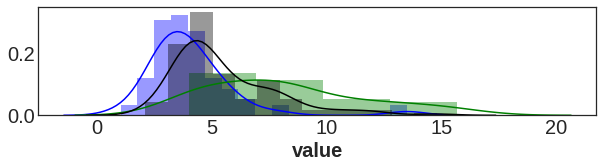

In [34]:

plt.figure(figsize= (10,2))
sns.distplot(caffeine_absolute[smoking_idx(caffeine_absolute)]["value"], bins=None,   color="blue");
sns.distplot(caffeine_absolute[oc_idx(caffeine_absolute)]["value"], bins=None,  color="green");
#sns.distplot(caffeine_absolute[oc_smoking_strict(caffeine_absolute)]["value"], bins=20,   label="oc_smoking");
sns.distplot(caffeine_absolute[control_idx(caffeine_absolute)]["value"], bins=None, color="black");
#sns.distplot(caffeine_thalf[rest_idx(caffeine_thalf)]["value"], bins=20, kde=False, label="unknown");

plt.legend()



In [35]:

caffeine_absolute = caffeine_thalf[caffeine_thalf["unit"]=="hour"]
caffeine_absolute = caffeine_absolute[caffeine_absolute["unit_intervention"] == "gram"]
caffeine_absolute = caffeine_absolute.dropna(subset=["mean"])
caffeine_absolute = caffeine_absolute[~caffeine_absolute["outlier"]]

frames = []
for i, data in caffeine_absolute.iterrows():
    for _ in range(int(data["group_count"])):
        data["value"] = data["mean"]
        frames.append(data)

caffeine_absolute1 =  pd.concat(frames, axis=1).T


frames = []
for i, data in caffeine_absolute.iterrows():
    mean = data["mean"]
    sd = data["sd"]
    for _ in range(int(data["group_count"])):
        
        if not np.isnan(sd):
            value = -1

            while value < 0:
                value = np.random.normal(mean,sd)
            data["value"] = value

            

        else:
            data["value"] = data["mean"]
            
        frames.append(data)

caffeine_absolute2 =  pd.concat(frames, axis=1).T


In [36]:
len(caffeine_absolute2)

1156

In [37]:
caffeine_absolute = caffeine_thalf[caffeine_thalf["unit"]=="hour"]
caffeine_absolute = caffeine_absolute[caffeine_absolute["unit_intervention"] == "gram"]
caffeine_absolute = caffeine_absolute[~caffeine_absolute["outlier"]]
len(caffeine_absolute)

421

In [38]:
#caffeine_absolute = caffeine_absolute1
#caffeine_absolute = caffeine_absolute2
#caffeine_absolute = caffeine_absolute.reset_index()

caffeine_absolute = caffeine_absolute.dropna(subset=["value"]).append(caffeine_absolute1)
len(caffeine_absolute)

1465

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


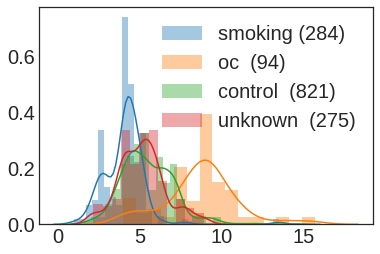

In [39]:
smoking = caffeine_absolute[smoking_idx(caffeine_absolute)]["value"].to_list()
oc = caffeine_absolute[oc_idx(caffeine_absolute)]["value"].to_list()
control = caffeine_absolute[control_idx(caffeine_absolute)]["value"].to_list()
rest = caffeine_absolute[rest_idx(caffeine_absolute)]["value"].to_list()

sns.distplot(smoking, bins=None,   label=f"smoking ({len(smoking)})")
sns.distplot(oc, bins=None,  label=f"oc  ({len(oc)})")
sns.distplot(control, bins=None, label=f"control  ({len(control)})")
sns.distplot(rest, bins=None, label=f"unknown  ({len(rest)})")

plt.legend()

/home/janekg89/Envs/pkdb_analysis/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


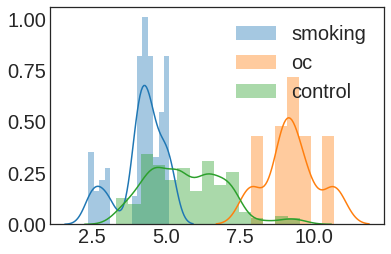

In [40]:
#caffeine_absolute = caffeine_absolute1
caffeine_absolute = caffeine_absolute1
caffeine_absolute = caffeine_absolute.reset_index()

sns.distplot(caffeine_absolute[smoking_idx(caffeine_absolute)]["mean"].to_list(), bins=None,   label="smoking")
sns.distplot(caffeine_absolute[oc_idx(caffeine_absolute)]["mean"].to_list(), bins=None,  label="oc")
sns.distplot(caffeine_absolute[control_idx(caffeine_absolute)]["mean"].to_list(), bins=None, label="control")
plt.legend()

In [41]:
caffeine_instance = PkdbModel("caffeine_vd",destination="3-inferred")
caffeine_instance.read()
caffeine_instance_data = caffeine_instance.data
caffeine_instance_data["outlier"] = False
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Balogh1992","outlier"] = True
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Harder1988","outlier"] = True
caffeine_instance_data.loc[caffeine_instance_data["study"]== "Harder1989","outlier"] = True

In [42]:
caffeine_instance_data.columns.to_list()

#yinterp = interpolate.UnivariateSpline(x, y, s = 5e8)(x) 


['study',
 'output_type',
 'pk',
 'raw_pk',
 'tissue',
 'interventions',
 'unit',
 'substance_name',
 'pktype',
 'calculated',
 'individual_pk',
 'value',
 'group_pk',
 'group_count',
 'mean',
 'timecourse_pk',
 'time_unit',
 'time',
 'se',
 'cv',
 'sd',
 'pharmacokinetics',
 'figure',
 'max',
 'min',
 'median',
 'raw_pk_intervention',
 'category',
 'route',
 'unit_intervention',
 'substance_name_intervention',
 'value_intervention',
 'application',
 'time_intervention',
 'time_unit_intervention',
 'form',
 'choice',
 'min_intervention',
 'max_intervention',
 'se_intervention',
 'subject_type',
 'subject_pk',
 ('study', ''),
 ('subject_name', ''),
 ('species', 'choice'),
 ('species', 'count'),
 ('healthy', 'choice'),
 ('healthy', 'count'),
 ('sex', 'choice'),
 ('sex', 'count'),
 ('age', 'count'),
 ('age', 'max'),
 ('age', 'mean'),
 ('age', 'median'),
 ('age', 'min'),
 ('age', 'sd'),
 ('age', 'se'),
 ('age', 'unit'),
 ('age', 'value'),
 ('smoking', 'choice'),
 ('smoking', 'count'),
 ('a

In [43]:
import matplotlib.pyplot as plt
from scipy import interpolate

unit_intervention = "gram"
unit = "liter / hour"

caffeine_abs_abs= caffeine_clearance[(caffeine_clearance["unit_intervention"] == unit_intervention) &(caffeine_clearance["unit"] == unit)]#[["value","value_intervention"]]
caffeine_abs_abs["value"] = caffeine_abs_abs["mean"]
for category in categories_soft:
    d = caffeine_abs_abs[category.data_idx(caffeine_abs_abs)]
    d.sort_values("value_intervention", inplace=True)
    linear_fit = np.polyfit(d["value_intervention"], d["value"], 3)
    plt.
    #sns.regplot("value_intervention","value", d, order=3,truncate=True, label =category.name,)
    
    #yinterp = interpolate.UnivariateSpline(d["value_intervention"],d["value"], s = 5e8)(d["value_intervention"]) 
    #plt.plot(x, y, 'bo', label = 'Original')
    #plt.plot(x, yinterp, 'r', label = 'Interpolated'
plt.legend()

SyntaxError: invalid syntax (<ipython-input-43-d3ce25adb2b5>, line 13)

In [ ]:
caffeine_clearance[(caffeine_clearance["outlier"] == False) &
(caffeine_clearance["unit_intervention"] == "gram / kilogram") &(caffeine_clearance["unit"] == "liter / hour / kilogram")].sort_values("value",ascending=False)[["study","value"]]